In [1]:
import sys
!{sys.executable} -m pip install tabulate

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pprint import pprint
from tabulate import tabulate
from datetime import datetime, timedelta

## Preliminary Analysis


To get familiar with the dataset and remove the outliers.

• What is the distribution of trip distance of different types of roads? Plot ecdf and make comments.



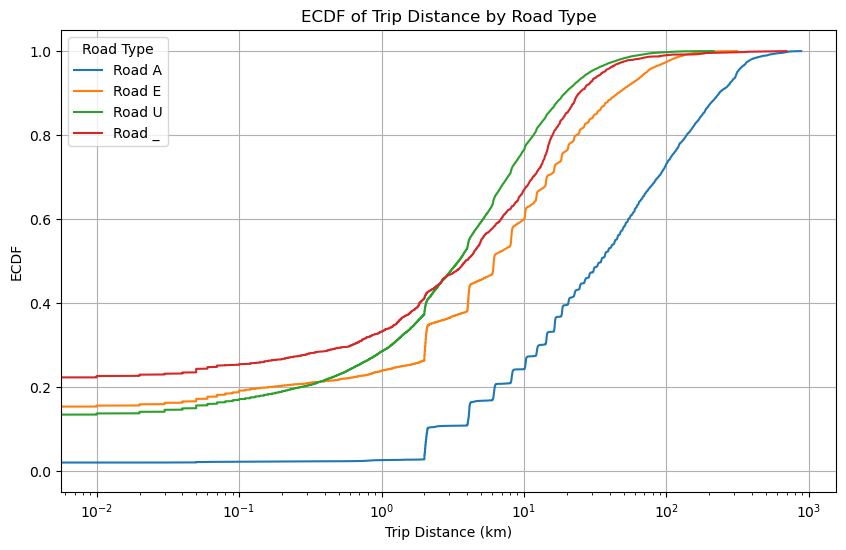

' Observations:\nUrban Roads (U): These trips typically have shorter distances, as seen by the steep rise in the ECDF at smaller distances.\nExpressways (E): The distances are more spread out, with a smoother, less steep ECDF curve, indicating longer trip distances on average.\n'

In [3]:
# Load the uploaded CSV file to explore its contents
file_path = r'./Lab3/Unipol_dataset_lab3.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head(), data.columns

# Extract relevant columns for analysis
road_types = data['road']
distances = data['total_distance']

# Check for missing or invalid values in relevant columns
data_cleaned = data.dropna(subset=['road', 'total_distance'])

# Group by road type and calculate ECDF for each group
road_groups = data_cleaned.groupby('road')

# Function to compute ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Plot ECDF for each road type
plt.figure(figsize=(10, 6))
for road, group in road_groups:
    x, y = ecdf(group['total_distance'])
    plt.semilogx(x, y, label=f'Road {road}')

# Customize the plot
plt.title('ECDF of Trip Distance by Road Type')
plt.xlabel('Trip Distance (km)')
plt.ylabel('ECDF')
plt.legend(title='Road Type')
plt.grid(True)

# Display the plot
plt.show()



''' Observations:
Urban Roads (U): These trips typically have shorter distances, as seen by the steep rise in the ECDF at smaller distances.
Expressways (E): The distances are more spread out, with a smoother, less steep ECDF curve, indicating longer trip distances on average.
'''

• What is the distribution of trip duration? Plot ecdf and make comments.



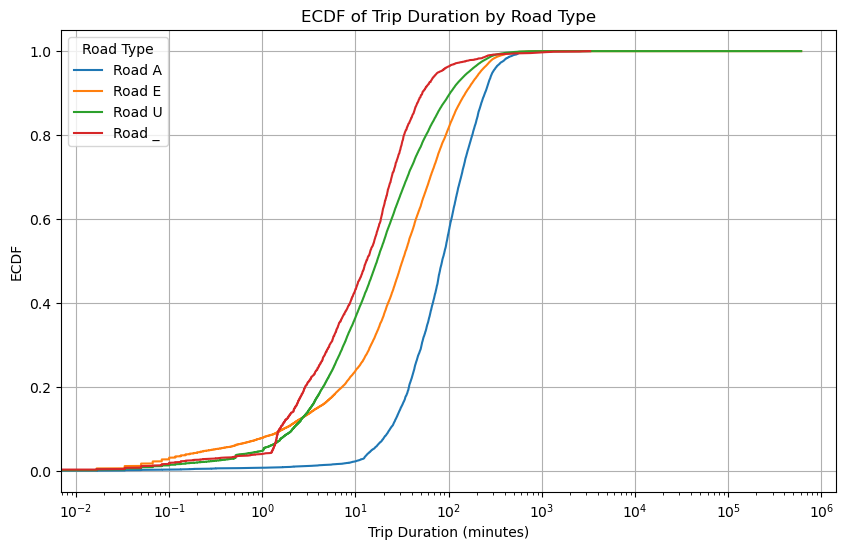

In [4]:
# Convert start_time and stop_time to datetime
data_cleaned['start_time'] = pd.to_datetime(data_cleaned['start_time'])
data_cleaned['stop_time'] = pd.to_datetime(data_cleaned['stop_time'])

# Calculate trip duration in minutes
data_cleaned['trip_duration'] = (data_cleaned['stop_time'] - data_cleaned['start_time']).dt.total_seconds() / 60

# Group by road type and calculate ECDF for trip duration
road_groups_duration = data_cleaned.groupby('road')

# Plot ECDF for trip duration for each road type
plt.figure(figsize=(10, 6))
for road, group in road_groups_duration:
    x, y = ecdf(group['trip_duration'])
    plt.semilogx(x, y, label=f'Road {road}')

# Customize the plot
plt.title('ECDF of Trip Duration by Road Type')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('ECDF')
plt.legend(title='Road Type')
plt.grid(True)


# Display the plot
plt.show()


• What is the relationship between trip duration and distance? Can you spot any difference among
trips with different road types?


Correlation between trip duration and distance for each road type:
Road A: 0.74
Road E: 0.01
Road U: 0.01
Road _: 0.16


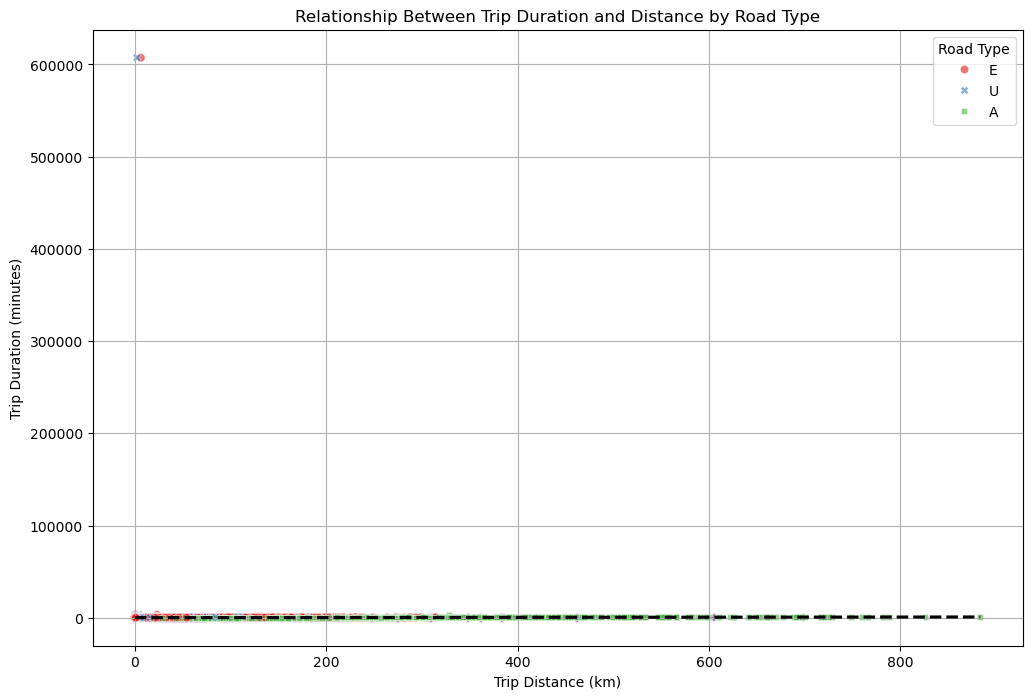

In [5]:
# Calculate correlation coefficients between trip duration and distance for each road type
road_correlation = {}
for road, group in road_groups:
    corr = group['trip_duration'].corr(group['total_distance'])
    road_correlation[road] = corr

# Display correlation coefficients
print("Correlation between trip duration and distance for each road type:")
for road, corr in road_correlation.items():
    print(f"Road {road}: {corr:.2f}")

# Scatter plot with regression lines for each road type
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data_cleaned,
    x='total_distance',
    y='trip_duration',
    hue='road',
    style='road',
    palette='Set1',
    alpha=0.6
)
sns.regplot(
    data=data_cleaned,
    x='total_distance',
    y='trip_duration',
    scatter=False,
    line_kws={"linestyle": "dashed", "color": "black"}
)

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration (minutes)')
plt.legend(title='Road Type')
plt.grid(True)


# Display the plot
plt.show()



• Filter the dataset, remove outliers (e.g. distance 0, impossible distance wrt duration) and report your
filter criteria. How many valid trips are recorded in the dataset?

In [6]:
# Define filtering criteria
min_distance = 0.1  # Minimum valid distance in km
max_distance = 1500  # Maximum valid distance in km
min_duration = 0.5  # Minimum valid trip duration in minutes
max_duration = 2500  # Maximum valid trip duration in minutes --> METTI 2500 MINUTES
min_speed = 1  # Minimum average speed in km/h
max_speed = 200  # Maximum reasonable average speed in km/h

# Filter dataset: Remove rows with zero or negative distance/duration
filtered_data = data_cleaned[
    (data_cleaned['total_distance'] > min_distance) &
    (data_cleaned['total_distance'] <= max_distance) &
    (data_cleaned['trip_duration'] > min_duration) &
    (data_cleaned['trip_duration'] <= max_duration)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Calculate average speed (km/h) and filter based on speed thresholds
filtered_data['average_speed'] = (
    filtered_data['total_distance'] / (filtered_data['trip_duration'] / 60)
)

filtered_data = filtered_data[
    (filtered_data['average_speed'] >= min_speed) &
    (filtered_data['average_speed'] <= max_speed)
]

# Count the number of valid trips
valid_trip_count = len(filtered_data)

# Display the filtering criteria and valid trip count
print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and ≤ {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and ≤ {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

# Output the first few rows of the filtered data for verification
print("\nSample of filtered data:")
print(filtered_data.head())

output_file = "filtered_trips.csv"
filtered_data.to_csv(output_file, index=False)

print(f"\nDati filtrati salvati in '{output_file}'.")

Filtering Criteria:
1. Total distance > 0.1 km and ≤ 1500 km
2. Trip duration > 0.5 minutes and ≤ 2500 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 57538

Sample of filtered data:
   Unnamed: 0  vehicle_id  trip_id          start_time           stop_time  \
0           0           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
1           1           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
3           3           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
4           4           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
5           5           1        3 2023-09-29 15:37:38 2023-09-29 15:57:26   

  road  total_distance  trip_duration  average_speed  
0    E           14.31      16.116667      53.274043  
1    U            1.47      16.116667       5.472596  
3    E            2.60      14.866667      10.493274  
4    U            2.00      14.866667       8.071749  
5    E            2.24      19.800000       6

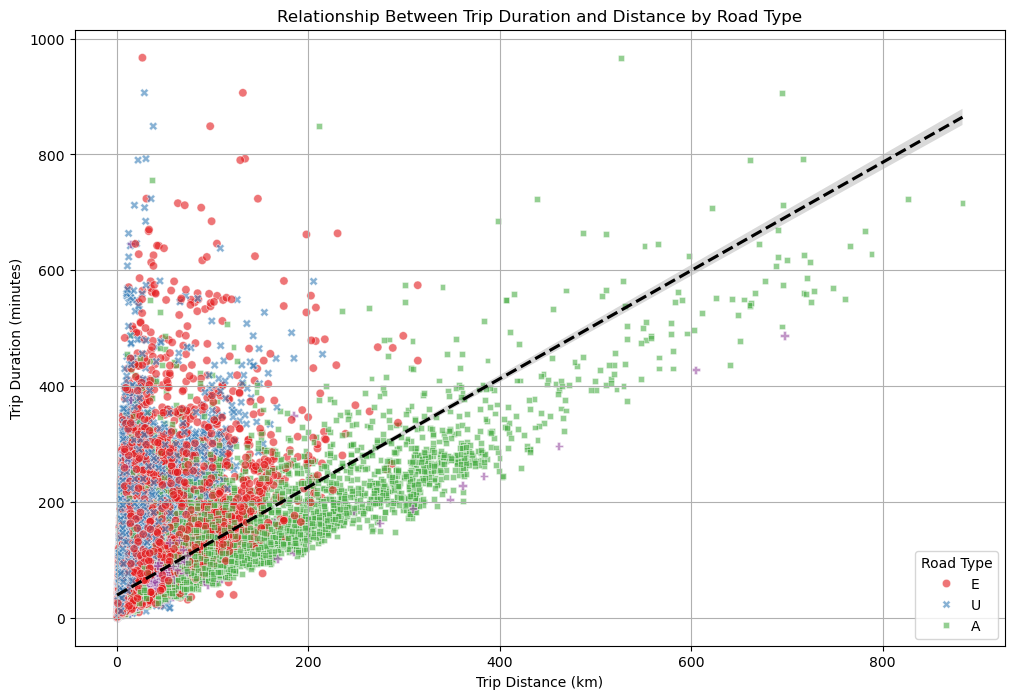

In [7]:
# Scatter plot with regression lines for each road type
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=filtered_data,  # Use filtered data
    x='total_distance',
    y='trip_duration',
    hue='road',
    style='road',
    palette='Set1',
    alpha=0.6
)
sns.regplot(
    data=filtered_data,  # Use filtered data
    x='total_distance',
    y='trip_duration',
    scatter=False,
    line_kws={"linestyle": "dashed", "color": "black"}
)

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration (minutes)')
plt.legend(title='Road Type')
plt.grid(True)



# Display the plot
plt.show()


## Tasks


## 1. Analysing behaviours of vehicles. For each vehicle, aggregate the data on daily basis, compute
following values:

(i) number of trips;

(ii) total travel distance;

(iii) utilization percentage, i.e. fraction of driving time in the 24 hours.




In [8]:
# Load the dataset
#file_path = r"Unipol_dataset_lab3.csv"  # Replace with the actual file path
data = filtered_data

# Convert time columns to datetime format
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])
data['date'] = data['start_time'].dt.date  # Extract date from start_time

# Add a column to indicate the type of day (weekday or weekend)
data['day_type'] = data['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate driving time per trip in seconds
data['driving_time'] = (data['stop_time'] - data['start_time']).dt.total_seconds()

# Aggregate data on a daily basis for each vehicle
aggregated = data.groupby(['vehicle_id', 'date', 'road', 'day_type']).agg(
    total_distance=('total_distance', 'sum'),
    driving_time=('driving_time', 'sum'),
    num_trips=('trip_id', 'nunique')
).reset_index()

# Calculate utilization metrics
aggregated['daily_utilization'] = aggregated.groupby(['vehicle_id', 'date'])['driving_time'].transform('sum') / (24 * 3600)  # 24 hours

# Save the reorganized structure to a CSV file


output_file = "Unipol_dataset_aggregated_and_filtered.csv"
aggregated.to_csv(output_file, index=False)

print(f"\nDati filtrati salvati in '{output_file}'.")


Dati filtrati salvati in 'Unipol_dataset_aggregated_and_filtered.csv'.


In [9]:
aggregated.head()

,vehicle_id,date,road,day_type,total_distance,driving_time,num_trips,daily_utilization
0,1,2023-09-29,E,Weekday,19.150,3047.0,3,0.070532
1,1,2023-09-29,U,Weekday,5.480,3047.0,3,0.070532
2,1,2023-09-30,E,Weekend,6.130,2502.0,3,0.073808
3,1,2023-09-30,U,Weekend,5.050,3875.0,5,0.073808
4,1,2023-10-01,A,Weekend,200.989,16139.0,1,0.373588



1.a. Compute the statistics and distribution of the values on workdays and weekends/holidays.
Can you find any difference? Can you find some vehicles behave consistently?



  day_type road  total_trips  fraction
0  Weekday    A         6004  0.104348
1  Weekday    E        14754  0.256422
2  Weekday    U        24643  0.428291
3  Weekday    _         1235  0.021464
4  Weekend    A         1265  0.021985
5  Weekend    E         3064  0.053252
6  Weekend    U         6212  0.107963
7  Weekend    _          361  0.006274


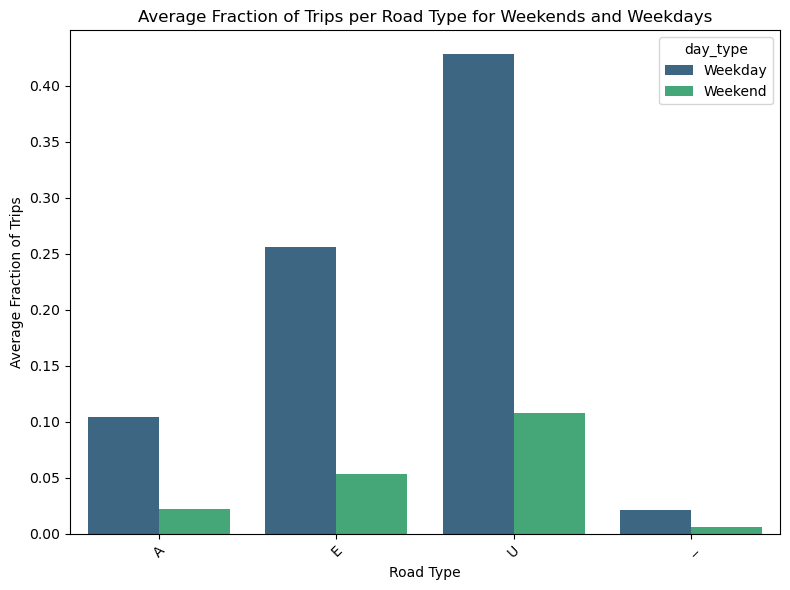

  day_type road  average_driving_time
0  Weekday    A          22129.770734
1  Weekday    E          25880.940516
2  Weekday    U          26435.170135
3  Weekday    _          20474.202020
4  Weekend    A          17949.042105
5  Weekend    E          19314.614509
6  Weekend    U          21545.416209
7  Weekend    _          18639.941176


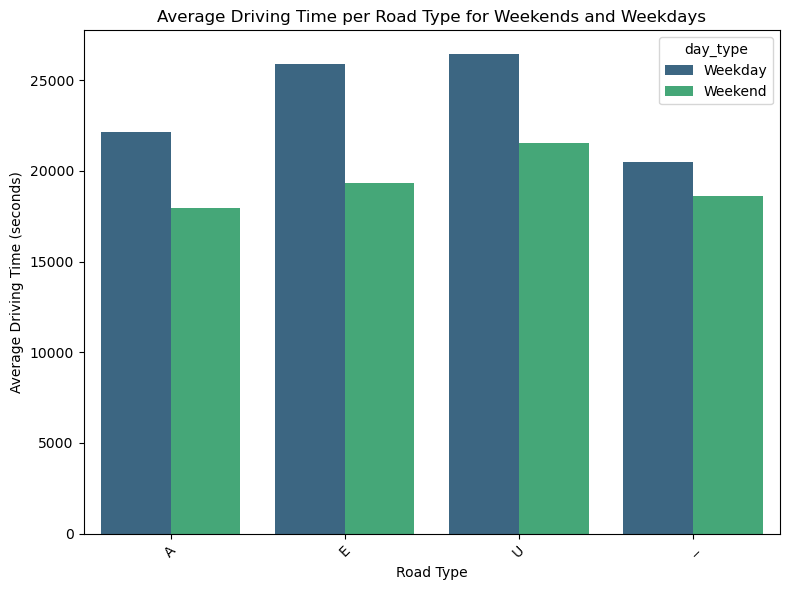

In [10]:
# FORSE MEGLIO CODICE SOTTO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file, but make sure to load the correct DataFrame that contains 'num_trips'
# You saved the aggregated data to 'Unipol_dataset_aggregated_and_filtered.csv', but it was actually 'filtered_data'
# Instead, you should have saved 'aggregated' to the CSV file

# Load the original CSV file for preliminary analysis (if 'aggregated' was not saved)
# original_data = pd.read_csv('./Lab3/Unipol_dataset_lab3.csv')
# filtered_data = original_data  # Skip the filtering if filtered_data is not available

# Convert time columns to datetime format for both datasets
# filtered_data['start_time'] = pd.to_datetime(filtered_data['start_time'])
# filtered_data['stop_time'] = pd.to_datetime(filtered_data['stop_time'])
# filtered_data['date'] = filtered_data['start_time'].dt.date  # Extract date from start_time
# filtered_data['day_type'] = filtered_data['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
# filtered_data['driving_time'] = (filtered_data['stop_time'] - filtered_data['start_time']).dt.total_seconds()

# # Aggregate data on a daily basis for each vehicle (re-create 'aggregated')
# aggregated = filtered_data.groupby(['vehicle_id', 'date', 'road', 'day_type']).agg(
#     total_distance=('total_distance', 'sum'),
#     driving_time=('driving_time', 'sum'),
#     num_trips=('trip_id', 'nunique')
# ).reset_index()

# aggregated['daily_utilization'] = aggregated.groupby(['vehicle_id', 'date'])['driving_time'].transform('sum') / (24 * 3600)  # 24 hours
# print(aggregated.head())
# # NOW, save the 'aggregated' DataFrame
# aggregated.to_csv("Unipol_dataset_aggregated_and_filtered.csv", index=False)

# Load the corrected aggregated data for analysis
data = pd.read_csv("Unipol_dataset_aggregated_and_filtered.csv")
# Step 1: Calculate average fraction of trips for weekends and weekdays
# Group by 'day_type' and 'road', and calculate the fraction
fraction_data = data.groupby(['day_type', 'road'], as_index=False).agg(
    total_trips=('num_trips', 'sum')
)
fraction_data['fraction'] = fraction_data['total_trips'] / fraction_data['total_trips'].sum()
print(fraction_data)
# Step 2: Visualize average fraction across road types for weekends and weekdays
plt.figure(figsize=(8, 6))
sns.barplot(data=fraction_data, x='road', y='fraction', hue='day_type', palette='viridis')
plt.title('Average Fraction of Trips per Road Type for Weekends and Weekdays')
plt.xlabel('Road Type')
plt.ylabel('Average Fraction of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Calculate average driving time for weekends and weekdays
# Group by 'day_type' and 'road', and calculate the mean driving time
driving_time_data = data.groupby(['day_type', 'road'], as_index=False).agg(
    average_driving_time=('driving_time', 'mean')
)
print(driving_time_data)
# Step 4: Visualize average driving time across road types for weekends and weekdays
plt.figure(figsize=(8, 6))
sns.barplot(data=driving_time_data, x='road', y='average_driving_time', hue='day_type', palette='viridis')
plt.title('Average Driving Time per Road Type for Weekends and Weekdays')
plt.xlabel('Road Type')
plt.ylabel('Average Driving Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Statistics for workdays and weekends/holidays:
         total_distance                              driving_time  \
                   mean         std   min       max          mean   
day_type                                                            
Weekday      424.830521  259.924285  0.17  1479.460  67587.578094   
Weekend      288.167567  230.032929  0.12  1379.395  49323.222080   

                                         num_trips                     
                   std    min       max       mean        std min max  
day_type                                                               
Weekday   33004.607382   44.0  238908.0  18.440490  10.363017   1  66  
Weekend   34842.448351  125.0  177133.0  13.994865  10.736023   1  56  
Statistics saved to vehicle_trip_statistics.csv
Vehicles with consistent behavior:
Empty DataFrame
Columns: [total_distance, driving_time, num_trips]
Index: []


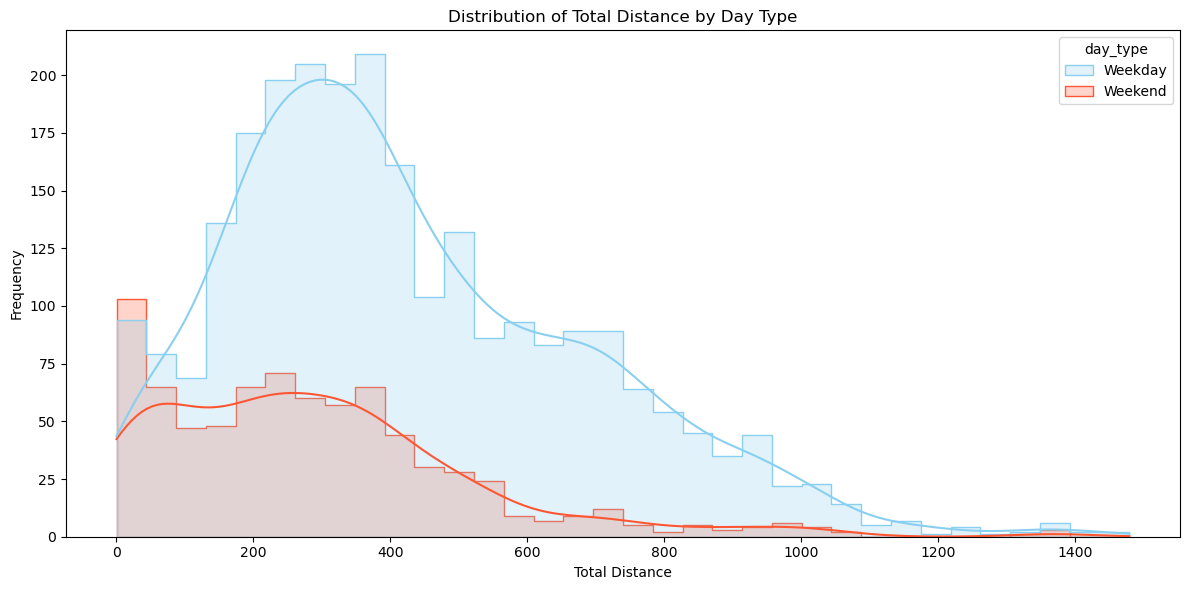

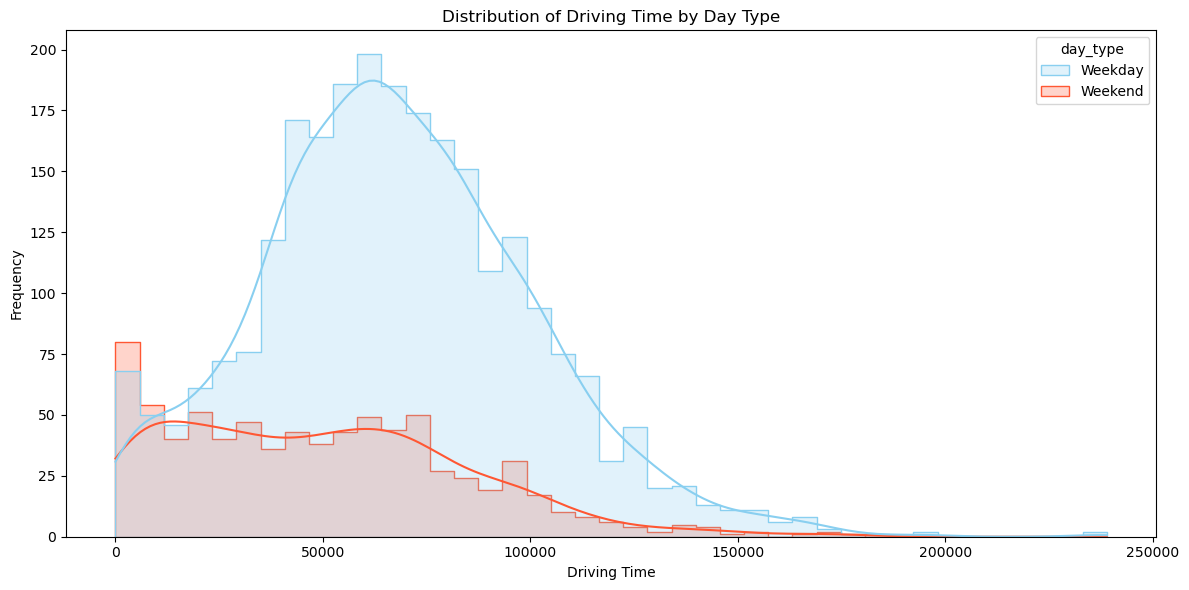

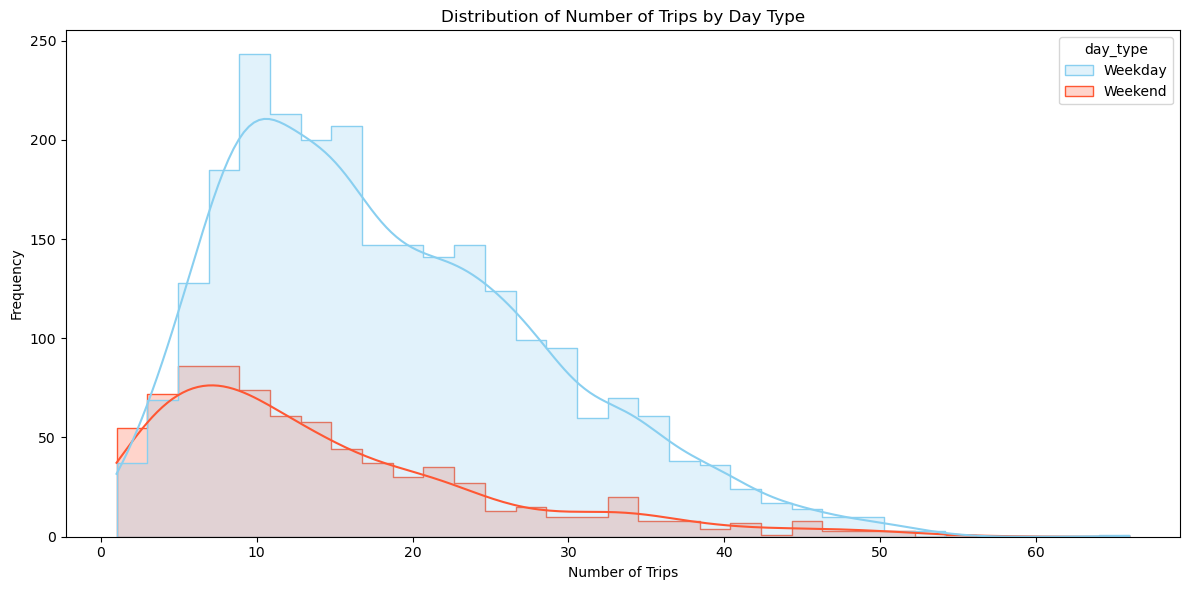

In [11]:
# METTI UNITA' DI MISURA
# Aggregated total_distance, driving_time, and num_trips per day for each vehicle to account for trips across multiple road types.
# Load the CSV file
data_file = r"Unipol_dataset_aggregated_and_filtered.csv"
data = pd.read_csv(data_file)

# Step 1: Aggregate data by vehicle_id, date, and day_type to handle trips across multiple roads
daily_data = data.groupby(['vehicle_id', 'date', 'day_type']).agg({
    'total_distance': 'sum',  # Sum distances across all road types
    'driving_time': 'sum',   # Sum driving times across all road types
    'num_trips': 'sum'       # Sum number of trips
}).reset_index()

# Step 2: Compute statistics for workdays and weekends/holidays
statistics = daily_data.groupby('day_type').agg({
    'total_distance': ['mean', 'std', 'min', 'max'],
    'driving_time': ['mean', 'std', 'min', 'max'],
    'num_trips': ['mean', 'std', 'min', 'max']
})

print("Statistics for workdays and weekends/holidays:")
print(statistics)
output_file = r"vehicle_trip_statistics.csv"
statistics.to_csv(output_file)

print(f"Statistics saved to {output_file}")


# Step 3: Check for consistent vehicle behavior
consistent_vehicles = daily_data.groupby(['vehicle_id', 'day_type']).agg({
    'total_distance': 'mean',
    'driving_time': 'mean',
    'num_trips': 'mean'
}).reset_index()

# Identify vehicles with consistent behavior by calculating the standard deviation across day types
vehicle_consistency = consistent_vehicles.groupby('vehicle_id').agg({
    'total_distance': 'std',
    'driving_time': 'std',
    'num_trips': 'std'
}).fillna(0)  # Replace NaN values with 0 for vehicles appearing only in one day type

consistent_behavior = vehicle_consistency[(vehicle_consistency['total_distance'] < 10) &
                                          (vehicle_consistency['driving_time'] < 10) &
                                          (vehicle_consistency['num_trips'] < 1)]

print("Vehicles with consistent behavior:")
print(consistent_behavior)

# Step 4: Visualize the distribution of values for workdays and weekends/holidays
custom_palette = ['#89CFF0', '#FF5733']  # Blue and orange

plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_distance', hue='day_type', kde=True, palette=custom_palette, element='step')
plt.title('Distribution of Total Distance by Day Type')
plt.xlabel('Total Distance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='driving_time', hue='day_type', kde=True, palette=custom_palette, element='step')
plt.title('Distribution of Driving Time by Day Type')
plt.xlabel('Driving Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='num_trips', hue='day_type', kde=True, palette=custom_palette, element='step')
plt.title('Distribution of Number of Trips by Day Type')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

1.b. For each vehicle, compute the fraction of its trips with different road types. Choose a
meaningful way to show the results and make comments.


Vehicle 1:
  Road: A, Fraction of trips: 0.21
  Road: E, Fraction of trips: 0.49
  Road: U, Fraction of trips: 0.31

Vehicle 2:
  Road: A, Fraction of trips: 0.29
  Road: E, Fraction of trips: 0.42
  Road: U, Fraction of trips: 0.29

Vehicle 3:
  Road: A, Fraction of trips: 0.23
  Road: E, Fraction of trips: 0.47
  Road: U, Fraction of trips: 0.29

Vehicle 4:
  Road: A, Fraction of trips: 0.05
  Road: E, Fraction of trips: 0.25
  Road: U, Fraction of trips: 0.71

Vehicle 5:
  Road: A, Fraction of trips: 0.22
  Road: E, Fraction of trips: 0.42
  Road: U, Fraction of trips: 0.35

Vehicle 6:
  Road: A, Fraction of trips: 0.13
  Road: E, Fraction of trips: 0.41
  Road: U, Fraction of trips: 0.46

Vehicle 7:
  Road: A, Fraction of trips: 0.14
  Road: E, Fraction of trips: 0.05
  Road: U, Fraction of trips: 0.80

Vehicle 8:
  Road: A, Fraction of trips: 0.04
  Road: E, Fraction of trips: 0.28
  Road: U, Fraction of trips: 0.68

Vehicle 9:
  Road: A, Fraction of trips: 0.18
  Road: E, Fractio

/tmp/ipykernel_4676/68915223.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_fraction, x='road', y='fraction', palette='viridis')


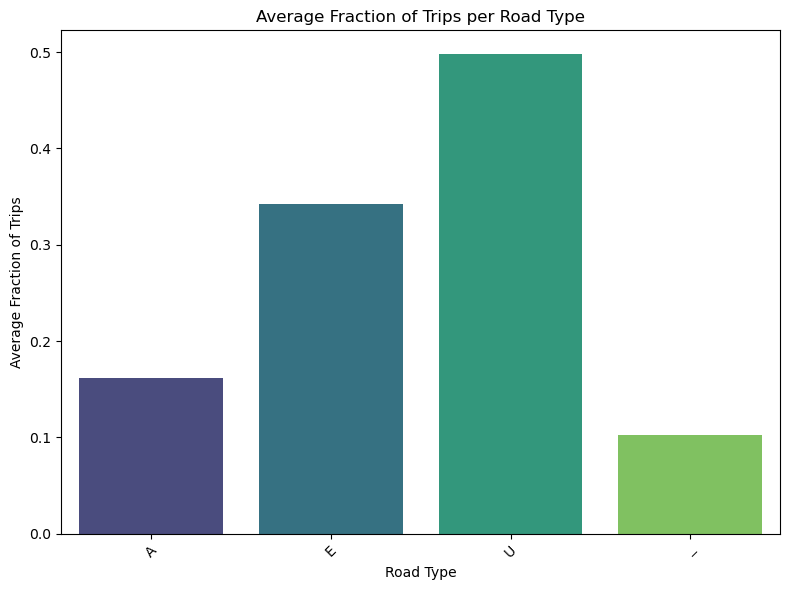

In [12]:
# Step 1: Load the CSV data
df = pd.read_csv(r"Unipol_dataset_aggregated_and_filtered.csv")

# Step 2: Group by 'vehicle_id' and 'road' to count trips
trip_counts = df.groupby(['vehicle_id', 'road'])['num_trips'].sum().reset_index()

# Step 3: Calculate total trips per vehicle
total_trips = df.groupby('vehicle_id')['num_trips'].sum().reset_index()
total_trips.rename(columns={'num_trips': 'total_trips'}, inplace=True)

# Step 4: Merge total trips with the trip counts
trip_counts = pd.merge(trip_counts, total_trips, on='vehicle_id')

# Step 5: Calculate the fraction of trips for each road type
trip_counts['fraction'] = trip_counts['num_trips'] / trip_counts['total_trips']

# Step 6: Display results for each vehicle (Optional for large datasets)
for vehicle_id in trip_counts['vehicle_id'].unique()[:10]:  # Limit output to the first 10 vehicles for clarity
    print(f"Vehicle {vehicle_id}:")
    vehicle_data = trip_counts[trip_counts['vehicle_id'] == vehicle_id]
    for _, row in vehicle_data.iterrows():
        print(f"  Road: {row['road']}, Fraction of trips: {row['fraction']:.2f}")
    print()

# Step 7: Summarize data: Average fraction per road type across all vehicles

# Step 8: Visualize average fraction across road types
plt.figure(figsize=(8, 6))
sns.barplot(data=average_fraction, x='road', y='fraction', palette='viridis')
plt.title('Average Fraction of Trips per Road Type')
plt.xlabel('Road Type')
plt.ylabel('Average Fraction of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Vehicle 1:
  Road: A, Fraction of trips: 0.21
  Road: E, Fraction of trips: 0.49
  Road: U, Fraction of trips: 0.31

Vehicle 2:
  Road: A, Fraction of trips: 0.29
  Road: E, Fraction of trips: 0.42
  Road: U, Fraction of trips: 0.29

Vehicle 3:
  Road: A, Fraction of trips: 0.23
  Road: E, Fraction of trips: 0.47
  Road: U, Fraction of trips: 0.29

Vehicle 4:
  Road: A, Fraction of trips: 0.05
  Road: E, Fraction of trips: 0.25
  Road: U, Fraction of trips: 0.71

Vehicle 5:
  Road: A, Fraction of trips: 0.22
  Road: E, Fraction of trips: 0.42
  Road: U, Fraction of trips: 0.35

Vehicle 6:
  Road: A, Fraction of trips: 0.13
  Road: E, Fraction of trips: 0.41
  Road: U, Fraction of trips: 0.46

Vehicle 7:
  Road: A, Fraction of trips: 0.14
  Road: E, Fraction of trips: 0.05
  Road: U, Fraction of trips: 0.80

Vehicle 8:
  Road: A, Fraction of trips: 0.04
  Road: E, Fraction of trips: 0.28
  Road: U, Fraction of trips: 0.68

Vehicle 9:
  Road: A, Fraction of trips: 0.18
  Road: E, Fractio

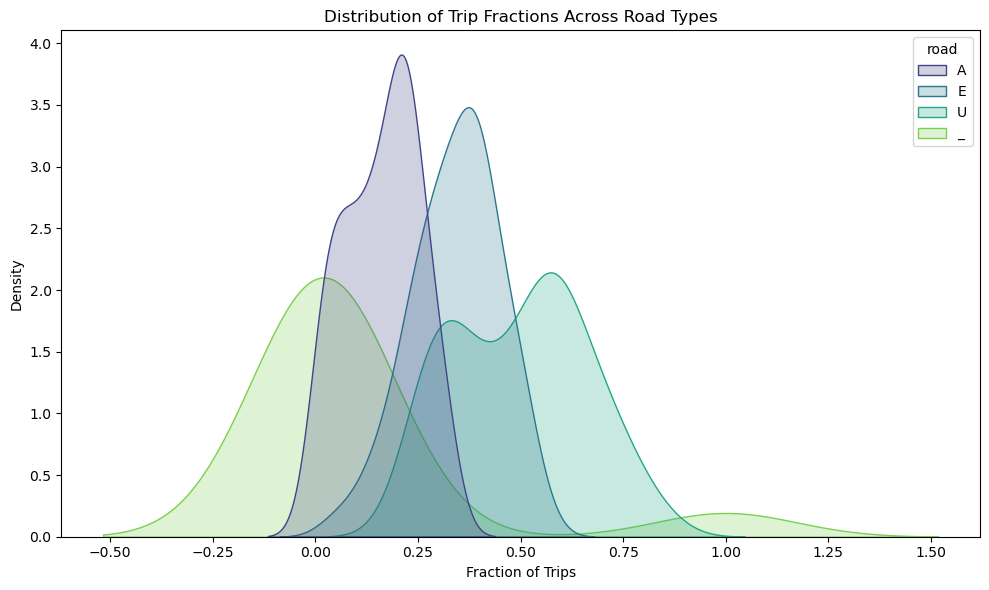

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the CSV data
df = pd.read_csv(r"Unipol_dataset_aggregated_and_filtered.csv")

# Step 2: Group by 'vehicle_id' and 'road' to count trips
trip_counts = df.groupby(['vehicle_id', 'road'])['num_trips'].sum().reset_index()

# Step 3: Calculate total trips per vehicle
total_trips = df.groupby('vehicle_id')['num_trips'].sum().reset_index()
total_trips.rename(columns={'num_trips': 'total_trips'}, inplace=True)

# Step 4: Merge total trips with the trip counts
trip_counts = pd.merge(trip_counts, total_trips, on='vehicle_id')

# Step 5: Calculate the fraction of trips for each road type
trip_counts['fraction'] = trip_counts['num_trips'] / trip_counts['total_trips']

# Step 6: Display results for each vehicle (Optional for large datasets)
for vehicle_id in trip_counts['vehicle_id'].unique()[:10]:  # Limit output to the first 10 vehicles for clarity
    print(f"Vehicle {vehicle_id}:")
    vehicle_data = trip_counts[trip_counts['vehicle_id'] == vehicle_id]
    for _, row in vehicle_data.iterrows():
        print(f"  Road: {row['road']}, Fraction of trips: {row['fraction']:.2f}")
    print()

# Step 7: Visualize the distribution of fractions across road types
plt.figure(figsize=(10, 6))
sns.kdeplot(data=trip_counts, x='fraction', hue='road', fill=True, common_norm=False, palette='viridis')
plt.title('Distribution of Trip Fractions Across Road Types')
plt.xlabel('Fraction of Trips')
plt.ylabel('Density')
plt.tight_layout()
plt.show()



1.c. According to the characters you find, categorize and cluster the vehicles into 3-5 types based
on their behaviours.

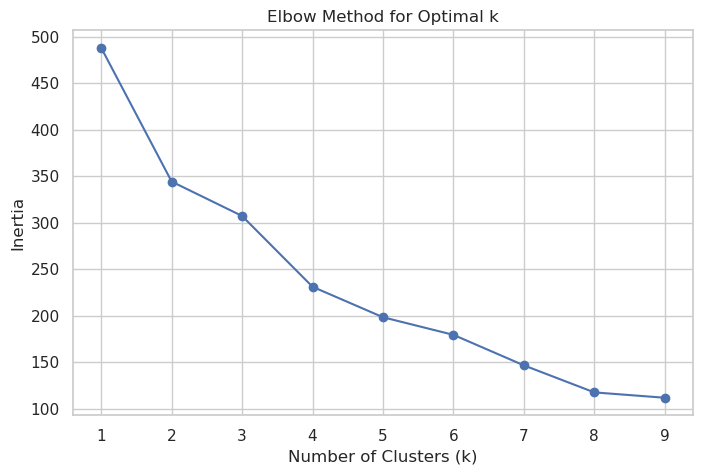

   vehicle_id  total_distance_A  total_distance_E  total_distance_U  \
0           1         16499.866          8972.230           975.180   
1           2         26399.630          6710.260          1039.980   
2           3         26903.090          7271.407          1399.777   
3           4           133.670          6597.900          7846.860   
4           5         24682.180          9247.150          1340.720   

   total_distance__  daily_utilization_A  daily_utilization_E  \
0               0.0             0.754742             0.652501   
1               0.0             1.115323             1.060207   
2               0.0             1.163779             1.094111   
3               0.0             0.613369             0.544172   
4               0.0             1.224829             1.083994   

   daily_utilization_U  daily_utilization__  Cluster  
0             0.696949                  0.0        1  
1             1.069699                  0.0        2  
2             1.0

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Load the dataset
data = pd.read_csv("Unipol_dataset_aggregated_and_filtered.csv")

# Aggregate data by vehicle_id
# Sum total_distance for each road and calculate mean daily_utilization per vehicle_id
aggregated_data = data.groupby(['vehicle_id', 'road']).agg({
    'total_distance': 'sum',
    'daily_utilization': 'mean'
}).unstack(fill_value=0)

# print(aggregated_data.head())

# Flatten the MultiIndex columns
aggregated_data.columns = [f"{col[0]}_{col[1]}" for col in aggregated_data.columns]
aggregated_data.reset_index(inplace=True)

# print(aggregated_data.head())

# Select relevant features for clustering (focusing on road usage and daily utilization)
road_features = [col for col in aggregated_data.columns if 'total_distance' in col]
utilization_feature = [col for col in aggregated_data.columns if 'daily_utilization' in col]
features = road_features + utilization_feature
selected_data = aggregated_data[features]

# Normalize the data for clustering
scaler = StandardScaler()
normalized_data = scaler.fit_transform(selected_data)

# print(normalized_data)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose the number of clusters (e.g., 3-5 based on the elbow curve)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Add cluster labels to the aggregated dataset
aggregated_data['Cluster'] = clusters

# print(aggregated_data.head())

# Analyze the clusters based on road usage and daily utilization
cluster_summary = aggregated_data.groupby('Cluster')[features].mean()
print("Cluster Summary:")
print(cluster_summary)

# Save the clustered dataset
aggregated_data.to_csv(r"clustered_vehicles.csv", index=False)


# Visualize the clusters using pairplot (for smaller feature sets)
if len(features) <= 5:
    sns.pairplot(aggregated_data, vars=features, hue='Cluster', palette='tab10')
    plt.title('Clusters Visualization')
    plt.show()





In [15]:

# Define the cluster summary data
data = {
    "Cluster": [0, 1, 2, 3],
    "Primary Behavior": [
        "Balanced Commuters",
        "Occasional High-Usage Drivers",
        "Highway and Extra-Urban Users",
        "Urban-Focused Drivers"
    ],
    "Total Distance": [
        "High on A and E, moderate on U",
        "Low on all roads, no use of -",
        "Very high on A, moderate on E, low on U",
        "High on U, moderate on A and E"
    ],
    "Daily Utilization": [
        "Moderate across A, E, U (0.8-1.1)",
        "Extremely high on U and E (9.8-12.5)",
        "Consistently moderate across all (0.8-1.0)",
        "Low to moderate (0.7-0.8)"
    ],
    "Comments": [
        "Users have balanced usage, prioritizing highways (A) with urban trips too.",
        "These are rare, intensive users who focus heavily on E and U roads.",
        "Users prioritize long-distance highway (A) and occasional extra-urban trips.",
        "These users are urban-centric, with frequent use of urban roads (U)."
    ]
}

# Create the DataFrame
cluster_summary = pd.DataFrame(data)

# Print the DataFrame as a well-formatted table
print(tabulate(cluster_summary, headers='keys', tablefmt='grid'))


+----+-----------+-------------------------------+-----------------------------------------+--------------------------------------------+------------------------------------------------------------------------------+
|    |   Cluster | Primary Behavior              | Total Distance                          | Daily Utilization                          | Comments                                                                     |
+====+===========+===============================+=========================================+============================================+==============================================================================+
|  0 |         0 | Balanced Commuters            | High on A and E, moderate on U          | Moderate across A, E, U (0.8-1.1)          | Users have balanced usage, prioritizing highways (A) with urban trips too.   |
+----+-----------+-------------------------------+-----------------------------------------+----------------------------------------


## 2. Choose at least three EV model from the EV database. Choose and define the evaluation metrics that you want to monitor. The mandatory one is the percentage of feasible trips.



In [16]:


cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": "25.0 kWh",
        "AC": {
            "Charge Power": "6.6 kW AC",
            "Charge Time (0->165 km)": "4h30m",
            "Charge Speed": "37 km/h"
        },
        "DC": {
            "Charge Power (max)": "34 kW DC",
            "Charge Power (10-80%)": "29 kW DC",
            "Charge Time (16->132 km)": "38 min",
            "Charge Speed": "180 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "98 Wh/km",
            "Highway - Mild Weather": "172 Wh/km",
            "Combined - Mild Weather": "132 Wh/km"
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": "80.7 kWh",
        "AC": {
            "Charge Power": "11 kW AC",
            "Charge Time (0->515 km)": "8h45m",
            "Charge Speed": "60 km/h"
        },
        "DC": {
            "Charge Power (max)": "207 kW DC",
            "Charge Power (10-80%)": "131 kW DC",
            "Charge Time (51->412 km)": "27 min",
            "Charge Speed": "800 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "109 Wh/km",
            "Highway - Mild Weather": "166 Wh/km",
            "Combined - Mild Weather": "136 Wh/km"
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": "109.0 kWh",
        "AC": {
            "Charge Power": "22 kW AC",
            "Charge Time (0->480 km)": "6 hours",
            "Charge Speed": "82 km/h"
        },
        "DC": {
            "Charge Power (max)": "367 kW DC",
            "Charge Power (10-80%)": "259 kW DC",
            "Charge Time (48->384 km)": "19 min",
            "Charge Speed": "1060 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "156 Wh/km",
            "Highway - Mild Weather": "242 Wh/km",
            "Combined - Mild Weather": "196 Wh/km"
        }
    }
}

# Track More Performance Metrics
performance_metrics_to_track = {
    "Unfeasible_trips": {
        "total": 0,  # Total number of unfeasible trips
        "percentage": 0.0  # Percentage of unfeasible trips
    },
    "Battery_average_SoC": {
        "total": 0.0,  # Total state of charge (SoC) in percentage
        "percentage": 0.0  # Percentage value of average SoC
    }
}


per la simulazione , il comportamento di ciascuna macchina EV scelta (DACIA, BMW, LOTUS in questo caso ) deve essere simulato per tutti i vehicle_id presenti, il tempo che passa da quando un viaggio finisce a quando ne inizia uno nuovo si chiama parking time solo se supera i 20 minuti, in questo lasso temporale il veicolo si può ricarica considerando i parametri specifici di ciascun veicolo.
in sostanza dovrei simulare il comportamento del veicolo 1 prima considerando come se fosse la DACIA scelta, poi la BMW scelta e poi la LOTUS scelta


## 3. Implement the replicator of trips and simulator of EV. Report it with diagram and/or pseudocode.




Pseudocode for Vehicle Battery Simulation

Data Preprocessing:

1. Load the dataset.
2. Sort the data by `vehicle_id` and `start_time`.

Initialization:

1. Define parameters:
    - Battery capacity
    - Energy consumption
    - Charging power
2. Create placeholders for:
    - Trip outcomes
    - Battery State of Charge (SoC)
    - Metrics

Simulation:

For each `vehicle_id`:
1. Initialize the full battery SoC.
2. For each trip:
    1. Calculate energy required for the trip.
    2. Check if SoC is sufficient:
        - If sufficient: Deduct energy and record the trip as feasible.
        - If insufficient: Record the trip as unfeasible.
3. Calculate parking duration before the next trip:
    - If parking time >= minimum charging time:
        - Recharge the battery based on charging power and parking duration.

Metrics Calculation:

1. Count unfeasible trips.
2. Calculate the average SoC across all trips.
3. Compare fast vs slow charging scenarios.

Visualization:

1. Generate diagrams showing:
    - SoC changes over trips.
    - Unfeasible trip counts.
    - Charging time distributions.


## 4. Conduct the simulation of all the vehicles, with different parameters (types of EV and chargingpower) and analyse the results.


In [17]:
import pandas as pd

# Load the CSV file
data = pd.read_csv(r"filtered_trips.csv")

# Convert start_time and stop_time to datetime for calculations
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Sort by vehicle_id, trip_id, and road type
data = data.sort_values(by=['vehicle_id', 'trip_id', 'road'])

# Initialize a list to store reformatted rows
reformatted_data = []

# Iterate through grouped data by vehicle and trip_id
for vehicle_id, group in data.groupby('vehicle_id'):
    group = group.sort_values('start_time')  # Ensure sorted by time within each vehicle group
    prev_stop_time = None  # Track the end of the previous trip

    for trip_id, trip_group in group.groupby('trip_id'):
        trip_start_time = trip_group['start_time'].iloc[0]
        trip_stop_time = trip_group['stop_time'].iloc[0]

        for _, row in trip_group.iterrows():
            # Calculate pause time if there is a previous stop time
            pause_time = (trip_start_time - prev_stop_time).total_seconds() / 60 if prev_stop_time else None

            reformatted_data.append({
                'vehicle_id': vehicle_id,
                'trip_id': trip_id,
                'road': row['road'],
                'start_date': trip_start_time.date(),
                'end_date': trip_stop_time.date(),
                'start_time': trip_start_time,
                'stop_time': trip_stop_time,
                'duration_minutes': row['trip_duration'],
                'total_distance': row['total_distance'],
                'pause_time_minutes': pause_time
            })

        # Update prev_stop_time
        prev_stop_time = trip_stop_time

# Create a DataFrame from the reformatted data
reformatted_df = pd.DataFrame(reformatted_data)
# Save the reformatted DataFrame to a CSV file
reformatted_df.to_csv(r"REFORMATTED_TRIPS.csv", index=False)

print(reformatted_df.head())


   vehicle_id  trip_id road  start_date    end_date          start_time  \
0           1        0    E  2023-09-29  2023-09-29 2023-09-29 13:55:35   
1           1        0    U  2023-09-29  2023-09-29 2023-09-29 13:55:35   
2           1        2    E  2023-09-29  2023-09-29 2023-09-29 15:12:03   
3           1        2    U  2023-09-29  2023-09-29 2023-09-29 15:12:03   
4           1        3    E  2023-09-29  2023-09-29 2023-09-29 15:37:38   

            stop_time  duration_minutes  total_distance  pause_time_minutes  
0 2023-09-29 14:11:42         16.116667           14.31                 NaN  
1 2023-09-29 14:11:42         16.116667            1.47                 NaN  
2 2023-09-29 15:26:55         14.866667            2.60           60.350000  
3 2023-09-29 15:26:55         14.866667            2.00           60.350000  
4 2023-09-29 15:57:26         19.800000            2.24           10.716667  


In [18]:
import pandas as pd

# Load the reformatted trips data
data = pd.read_csv(r"REFORMATTED_TRIPS.csv")

# Convert start_time and stop_time to datetime for calculations
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Define EV cars and performance metrics
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "AC": {
            "Charge Power": 6.6,  # kW
            "Charge Speed": 37  # km/h
        },
        "DC": {
            "Charge Power (max)": 34,  # kW
            "Charge Speed": 180  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 98,  # Wh/km
            "Highway": 172,  # Wh/km
            "Combined": 132  # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "AC": {
            "Charge Power": 11,  # kW
            "Charge Speed": 60  # km/h
        },
        "DC": {
            "Charge Power (max)": 207,  # kW
            "Charge Speed": 800  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 109,  # Wh/km
            "Highway": 166,  # Wh/km
            "Combined": 136  # Wh/km
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "AC": {
            "Charge Power": 22,  # kW
            "Charge Speed": 82  # km/h
        },
        "DC": {
            "Charge Power (max)": 367,  # kW
            "Charge Speed": 1060  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 156,  # Wh/km
            "Highway": 242,  # Wh/km
            "Combined": 196  # Wh/km
        }
    }
}

performance_metrics_to_track = {
    "Unfeasible_trips": {
        "total": 0,
        "percentage": 0.0
    },
    "Battery_average_SoC": {
        "total": 0.0,
        "percentage": 0.0
    }
}

def simulate_vehicle(vehicle_data, car_specs):
    """Simulate the behavior of a vehicle using a specific EV model."""
    SoC = car_specs["Useable Capacity"] * 1000  # Convert kWh to Wh
    total_unfeasible_trips = 0
    total_trips = 0
    total_SoC = 0

    for _, trip in vehicle_data.iterrows():
        total_trips += 1
        road_type = trip["road"]
        distance = trip["total_distance"]  # km

        # Determine energy consumption based on road type
        if road_type == "U":
            consumption_per_km = car_specs["Real_energy_consumption"]["Urban"]
        elif road_type == "A":
            consumption_per_km = car_specs["Real_energy_consumption"]["Highway"]
        else:  # Combined for other cases (E and unknown)
            consumption_per_km = car_specs["Real_energy_consumption"]["Combined"]

        energy_required = consumption_per_km * distance  # in Wh

        # Check if the trip is feasible
        if SoC >= energy_required:
            SoC -= energy_required
        else:
            total_unfeasible_trips += 1
            SoC = 0  # Assume arrival with 0% SoC

        # Simulate charging during pause time if applicable
        pause_time = trip["pause_time_minutes"]  # in minutes
        if pd.notnull(pause_time) and pause_time >= 20:
            charge_power = car_specs["AC"]["Charge Power"] * 60  # Wh per minute
            SoC += charge_power * pause_time
            SoC = min(SoC, car_specs["Useable Capacity"] * 1000)  # Cap at max capacity

        total_SoC += SoC

    unfeasible_percentage = (total_unfeasible_trips / total_trips) * 100
    average_SoC = total_SoC / total_trips if total_trips > 0 else 0

    return {
        "Unfeasible_trips": {
            "total": total_unfeasible_trips,
            "percentage": unfeasible_percentage
        },
        "Battery_average_SoC": {
            "total": total_SoC,
            "percentage": average_SoC / (car_specs["Useable Capacity"] * 1000) * 100
        }
    }

# Run the simulation for each vehicle and car model
results = []
for vehicle_id, vehicle_data in data.groupby("vehicle_id"):
    for car_name, car_specs in cars.items():
        result = simulate_vehicle(vehicle_data, car_specs)
        results.append({
            "vehicle_id": vehicle_id,
            "car_model": car_name,
            "total_unfeasible_trips": result["Unfeasible_trips"]["total"],
            "unfeasible_trip_percentage": result["Unfeasible_trips"]["percentage"],
            "total_SoC": result["Battery_average_SoC"]["total"],
            "average_SoC_percentage": result["Battery_average_SoC"]["percentage"]
        })

# Convert results to a DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv(r"EV_SIMULATION_RESULTS.csv", index=False)
print(results_df.head())


   vehicle_id                 car_model  total_unfeasible_trips  \
0           1  Dacia Spring Electric 45                      95   
1           1           BMW i4 eDrive40                       9   
2           1            Lotus Eletre S                       8   
3           2  Dacia Spring Electric 45                     117   
4           2           BMW i4 eDrive40                      17   

   unfeasible_trip_percentage     total_SoC  average_SoC_percentage  
0                   13.139696  1.458164e+07               80.672959  
1                    1.244813  5.392986e+07               92.430967  
2                    1.106501  7.306814e+07               92.717826  
3                   23.588710  1.032290e+07               83.249231  
4                    3.427419  3.524740e+07               88.058621  



  a. Report and comment how many trips are unfeasible (the SoC is or arrive at 0)




In [19]:
# see column total_unfeasible_trips in "EV_SIMULATION_RESULTS.csv", summarized in the cell below

def analyze_unfeasible_trips(vehicle_data, car_specs):
    """Analyze trips that are unfeasible because SoC is or arrives at 0."""
    SoC = car_specs["Useable Capacity"] * 1000  # Initialize SoC in Wh
    total_trips = 0
    unfeasible_due_to_SoC = 0

    for _, trip in vehicle_data.iterrows():
        total_trips += 1
        road_type = trip["road"]
        distance = trip["total_distance"]  # km

        # Determine energy consumption based on road type
        if road_type == "U":
            consumption_per_km = car_specs["Real_energy_consumption"]["Urban"]
        elif road_type == "A":
            consumption_per_km = car_specs["Real_energy_consumption"]["Highway"]
        else:  # Combined for other cases (E and unknown)
            consumption_per_km = car_specs["Real_energy_consumption"]["Combined"]

        energy_required = consumption_per_km * distance  # in Wh

        # Check if SoC reaches or starts at 0 for the trip
        if SoC < energy_required:
            unfeasible_due_to_SoC += 1
            SoC = 0  # Assume battery is depleted after an unfeasible trip
        else:
            SoC -= energy_required

        # Simulate charging during pause time if applicable
        pause_time = trip["pause_time_minutes"]  # in minutes
        if pd.notnull(pause_time) and pause_time >= 20:
            charge_power = car_specs["AC"]["Charge Power"] * 60  # Wh per minute
            SoC += charge_power * pause_time
            SoC = min(SoC, car_specs["Useable Capacity"] * 1000)  # Cap at max capacity

    return {
        "Total_trips": total_trips,
        "Unfeasible_due_to_SoC": unfeasible_due_to_SoC,
        "Percentage_unfeasible": (unfeasible_due_to_SoC / total_trips) * 100 if total_trips > 0 else 0
    }

# Run the analysis for each vehicle and car model
unfeasible_results = []
for vehicle_id, vehicle_data in data.groupby("vehicle_id"):
    for car_name, car_specs in cars.items():
        result = analyze_unfeasible_trips(vehicle_data, car_specs)
        unfeasible_results.append({
            "vehicle_id": vehicle_id,
            "car_model": car_name,
            **result
        })

# Convert results to a DataFrame and save
unfeasible_df = pd.DataFrame(unfeasible_results)
unfeasible_df.to_csv(r"UNFEASIBLE_TRIPS_ANALYSIS.csv", index=False)
print(unfeasible_df.head())


   vehicle_id                 car_model  Total_trips  Unfeasible_due_to_SoC  \
0           1  Dacia Spring Electric 45          723                     95   
1           1           BMW i4 eDrive40          723                      9   
2           1            Lotus Eletre S          723                      8   
3           2  Dacia Spring Electric 45          496                    117   
4           2           BMW i4 eDrive40          496                     17   

   Percentage_unfeasible  
0              13.139696  
1               1.244813  
2               1.106501  
3              23.588710  
4               3.427419  



Unfeasible Trips Summary with Context:
                  car_model  total_unfeasible_trips  \
0           BMW i4 eDrive40                     711   
1  Dacia Spring Electric 45                    8304   
2            Lotus Eletre S                     829   

   unfeasible_trip_percentage  Battery_Capacity_kWh  Urban_Consumption_Wh_km  \
0                    1.829183                  80.7                      109   
1                   17.309958                  25.0                       98   
2                    2.097231                 109.0                      156   

   Highway_Consumption_Wh_km  Combined_Consumption_Wh_km  
0                        166                         136  
1                        172                         132  
2                        242                         196  


/tmp/ipykernel_4676/3567150157.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


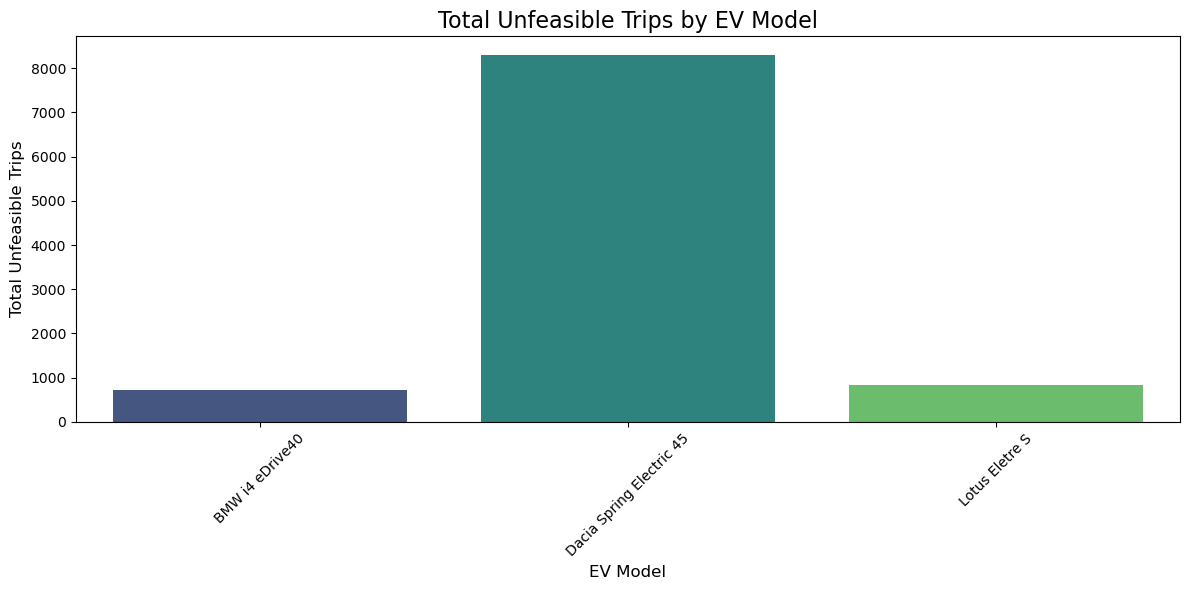

/tmp/ipykernel_4676/3567150157.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


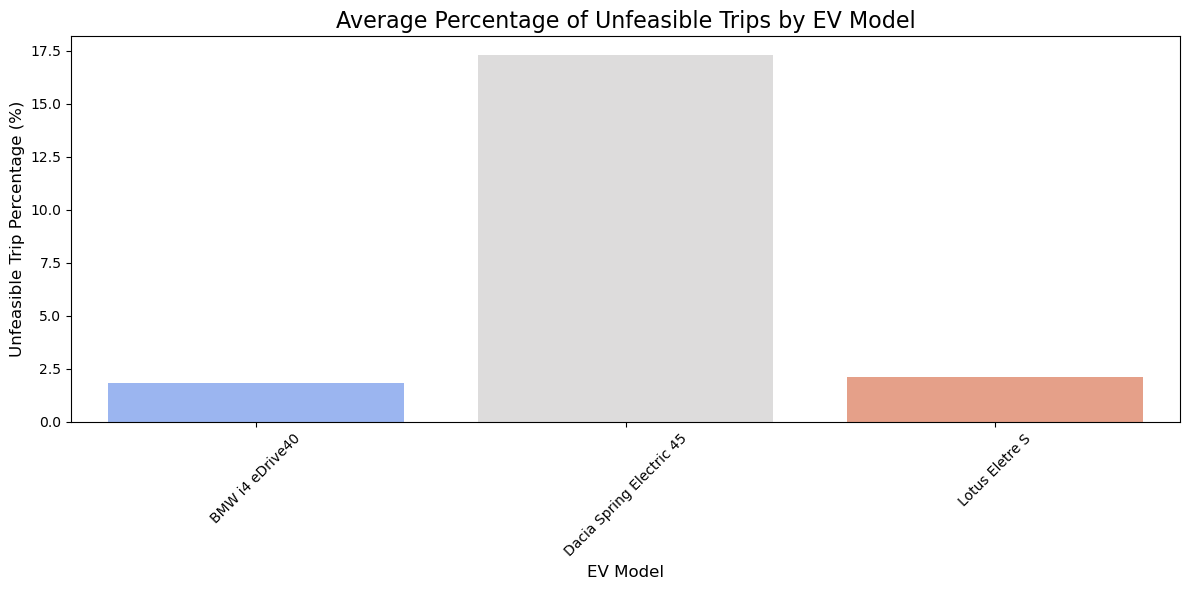

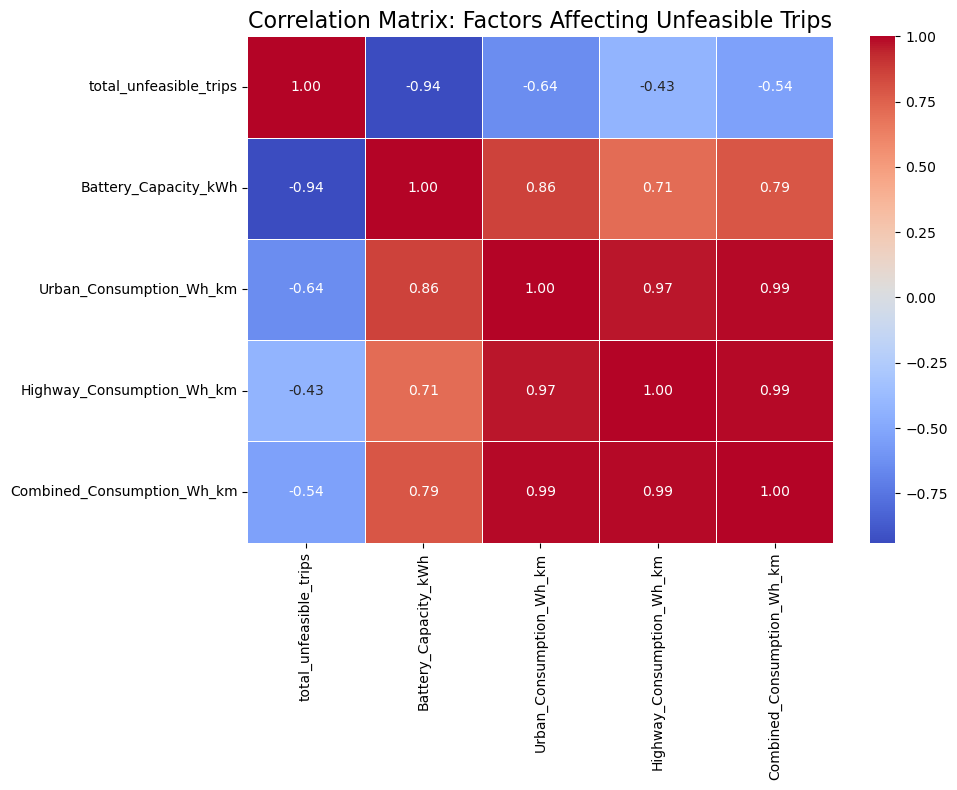

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the EV simulation results
results_df = pd.read_csv(r"EV_SIMULATION_RESULTS.csv")

# Define EV car specifications for additional context
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "Real_energy_consumption": {
            "Urban": 98,  # Wh/km
            "Highway": 172,  # Wh/km
            "Combined": 132  # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "Real_energy_consumption": {
            "Urban": 109,  # Wh/km
            "Highway": 166,  # Wh/km
            "Combined": 136  # Wh/km
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "Real_energy_consumption": {
            "Urban": 156,  # Wh/km
            "Highway": 242,  # Wh/km
            "Combined": 196  # Wh/km
        }
    }
}

# Summarize unfeasible trips across all vehicles and EV models
unfeasible_summary = results_df.groupby("car_model")[["total_unfeasible_trips", "unfeasible_trip_percentage"]].agg({
    "total_unfeasible_trips": "sum",
    "unfeasible_trip_percentage": "mean"
}).reset_index()

# Add additional context (battery capacity and consumption rates)
context_data = pd.DataFrame({
    "car_model": list(cars.keys()),
    "Battery_Capacity_kWh": [cars[model]["Useable Capacity"] for model in cars],
    "Urban_Consumption_Wh_km": [cars[model]["Real_energy_consumption"]["Urban"] for model in cars],
    "Highway_Consumption_Wh_km": [cars[model]["Real_energy_consumption"]["Highway"] for model in cars],
    "Combined_Consumption_Wh_km": [cars[model]["Real_energy_consumption"]["Combined"] for model in cars]
})
unfeasible_summary = unfeasible_summary.merge(context_data, on="car_model")

# Display the summary table
print("\nUnfeasible Trips Summary with Context:")
print(unfeasible_summary)

# Plot: Total unfeasible trips by EV model
plt.figure(figsize=(12, 6))
sns.barplot(
    data=unfeasible_summary,
    x="car_model",
    y="total_unfeasible_trips",
    palette="viridis"
)
plt.title("Total Unfeasible Trips by EV Model", fontsize=16)
plt.ylabel("Total Unfeasible Trips", fontsize=12)
plt.xlabel("EV Model", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Average percentage of unfeasible trips by EV model
plt.figure(figsize=(12, 6))
sns.barplot(
    data=unfeasible_summary,
    x="car_model",
    y="unfeasible_trip_percentage",
    palette="coolwarm"
)
plt.title("Average Percentage of Unfeasible Trips by EV Model", fontsize=16)
plt.ylabel("Unfeasible Trip Percentage (%)", fontsize=12)
plt.xlabel("EV Model", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional analysis: Correlation analysis to find reasons for poor performance
correlation_matrix = unfeasible_summary[[
    "total_unfeasible_trips",
    "Battery_Capacity_kWh",
    "Urban_Consumption_Wh_km",
    "Highway_Consumption_Wh_km",
    "Combined_Consumption_Wh_km"
]].corr()

# Plot: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix: Factors Affecting Unfeasible Trips", fontsize=16)
plt.tight_layout()
plt.show()


  b. Report and comment the distribution of performance metrics over vehicles.



Summary statistics:
                         total_unfeasible_trips                               \
                                          count        mean         std  min   
car_model                                                                      
BMW i4 eDrive40                            61.0   11.655738   18.193300  0.0   
Dacia Spring Electric 45                   61.0  136.131148  114.841699  9.0   
Lotus Eletre S                             61.0   13.590164   20.611790  0.0   

                                                   unfeasible_trip_percentage  \
                           25%   50%    75%    max                      count   
car_model                                                                       
BMW i4 eDrive40            0.0   2.0   18.0   84.0                       61.0   
Dacia Spring Electric 45  59.0  96.0  202.0  458.0                       61.0   
Lotus Eletre S             0.0   4.0   20.0  107.0                       61.0   

            

/tmp/ipykernel_4676/1127773609.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='car_model', y='unfeasible_trip_percentage', palette='muted')


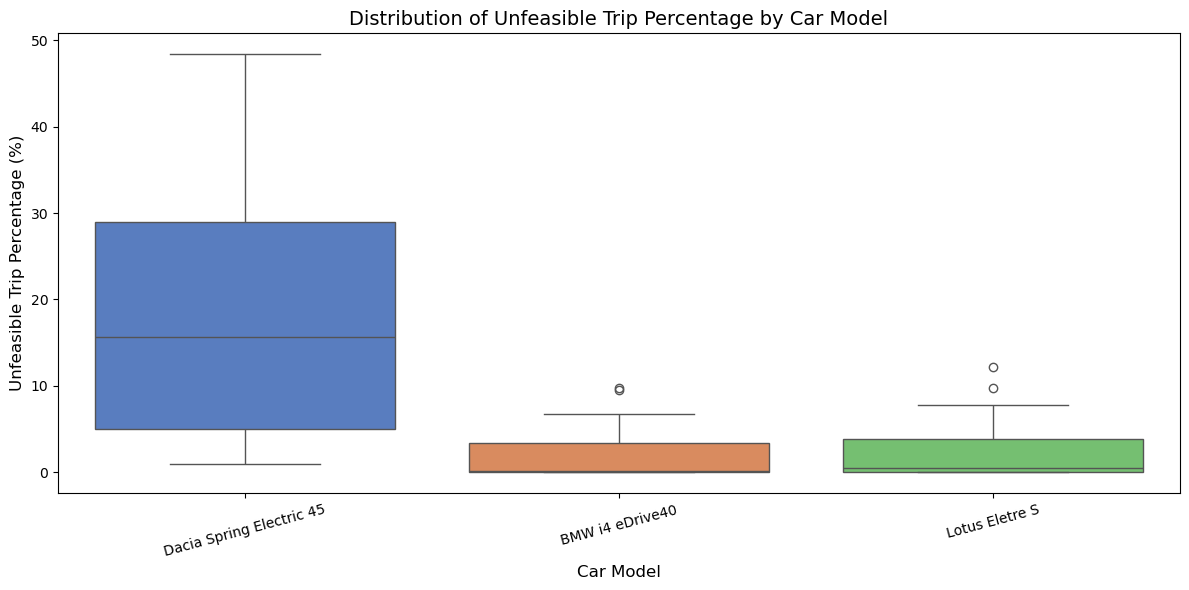

/tmp/ipykernel_4676/1127773609.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='car_model', y='average_SoC_percentage', palette='pastel')


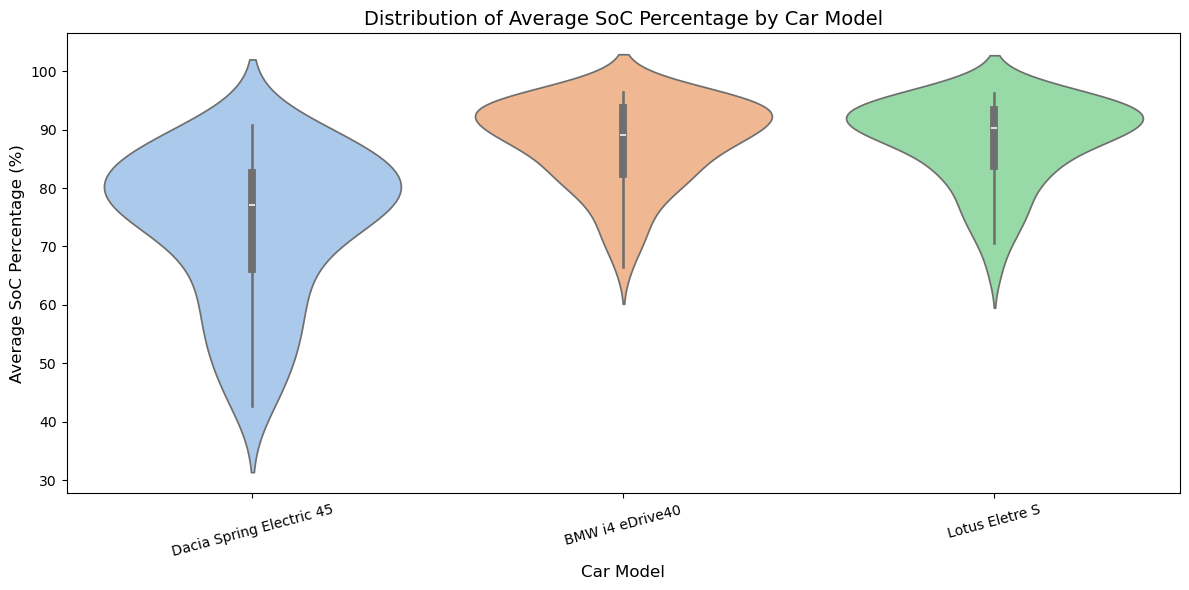

/tmp/ipykernel_4676/1127773609.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


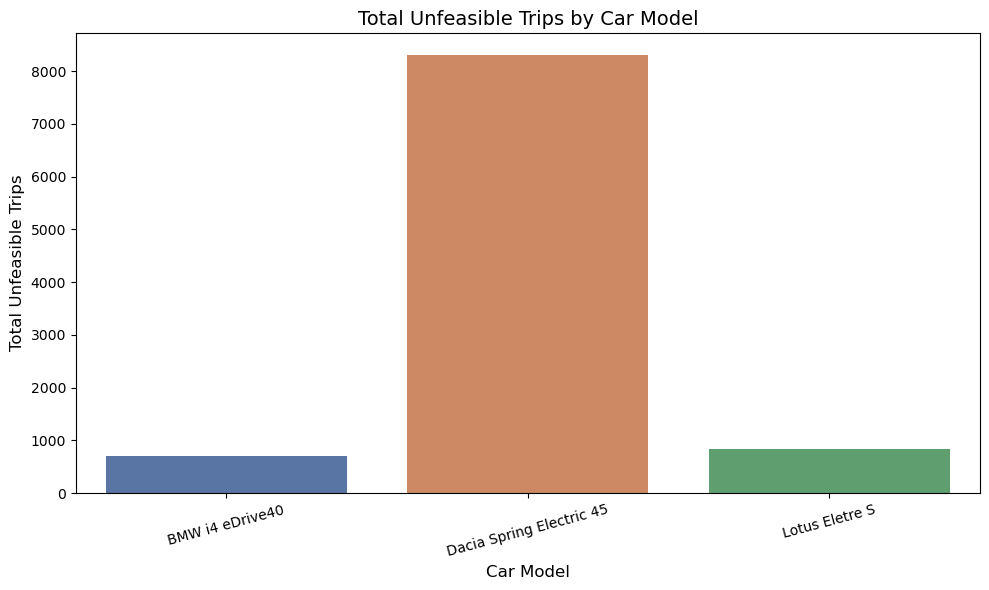

<Figure size 1200x600 with 0 Axes>

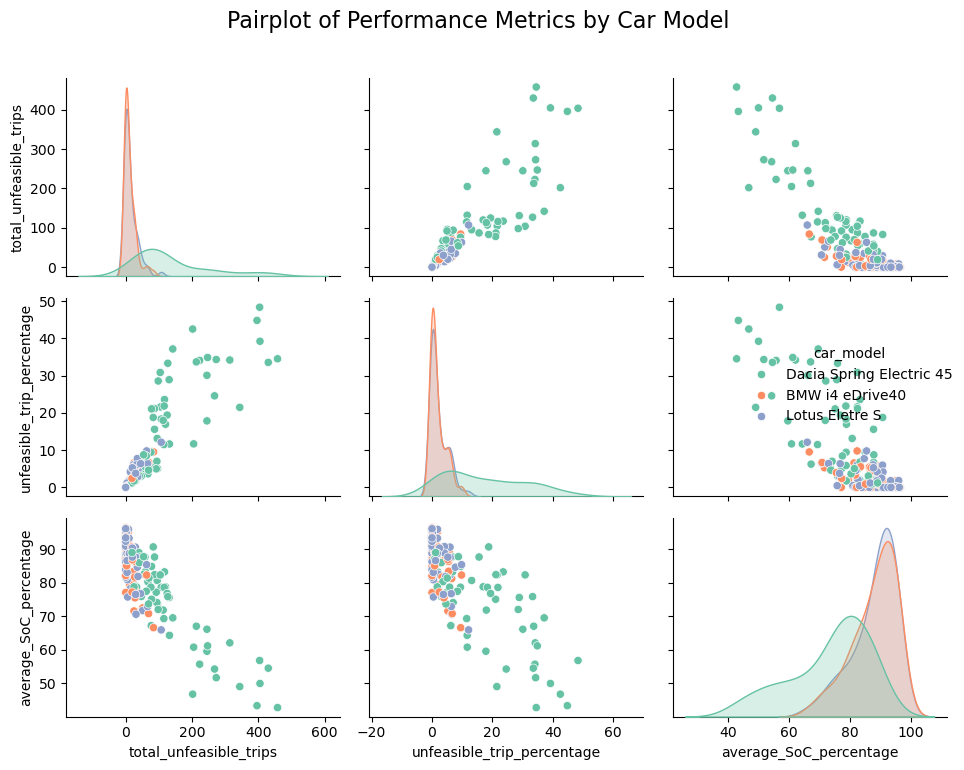

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load simulation results
data = pd.read_csv(r"EV_SIMULATION_RESULTS.csv")

# Filter results for the selected cars
selected_cars = ["Dacia Spring Electric 45", "BMW i4 eDrive40", "Lotus Eletre S"]
data = data[data['car_model'].isin(selected_cars)]

# Summary statistics for performance metrics
summary = data.groupby('car_model')[
    ['total_unfeasible_trips', 'unfeasible_trip_percentage', 'average_SoC_percentage']
].describe()
print("Summary statistics:")
print(summary)

# Visualization: Distribution of unfeasible trips
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='car_model', y='unfeasible_trip_percentage', palette='muted')
plt.title('Distribution of Unfeasible Trip Percentage by Car Model', fontsize=14)
plt.ylabel('Unfeasible Trip Percentage (%)', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualization: Distribution of average SoC percentage
plt.figure(figsize=(12, 6))
sns.violinplot(data=data, x='car_model', y='average_SoC_percentage', palette='pastel')
plt.title('Distribution of Average SoC Percentage by Car Model', fontsize=14)
plt.ylabel('Average SoC Percentage (%)', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualization: Total unfeasible trips per car model
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data.groupby('car_model')['total_unfeasible_trips'].sum().reset_index(),
    x='car_model',
    y='total_unfeasible_trips',
    palette='deep'
)
plt.title('Total Unfeasible Trips by Car Model', fontsize=14)
plt.ylabel('Total Unfeasible Trips', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualization: Pairplot for key metrics
plt.figure(figsize=(12, 6))
sns.pairplot(
    data,
    vars=['total_unfeasible_trips', 'unfeasible_trip_percentage', 'average_SoC_percentage'],
    hue='car_model',
    palette='Set2'
)
plt.suptitle('Pairplot of Performance Metrics by Car Model', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


  c. Is there any difference for different EV models? What about their consumption or charging
power?



/tmp/ipykernel_4676/1123457428.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_4676/1123457428.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


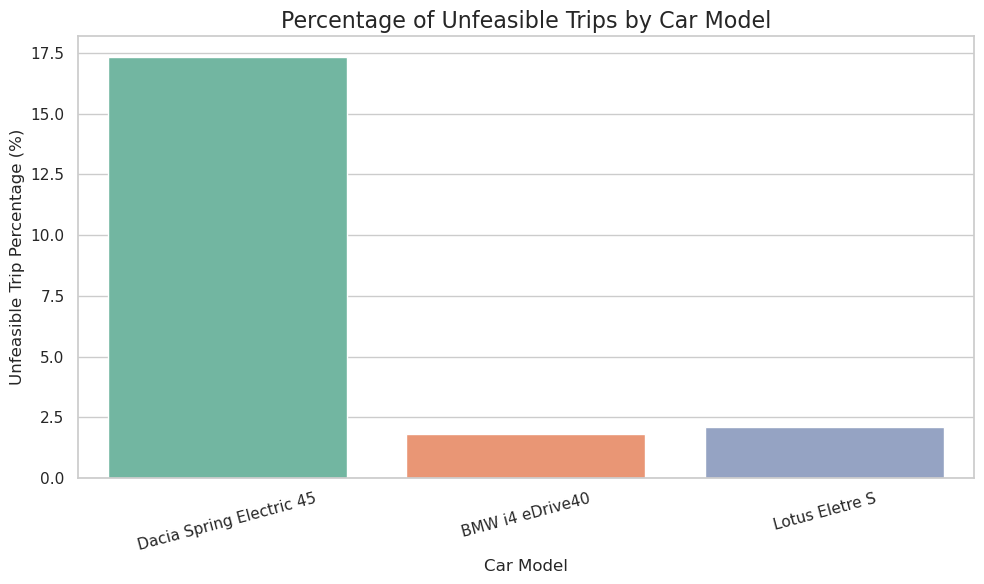

/tmp/ipykernel_4676/1123457428.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


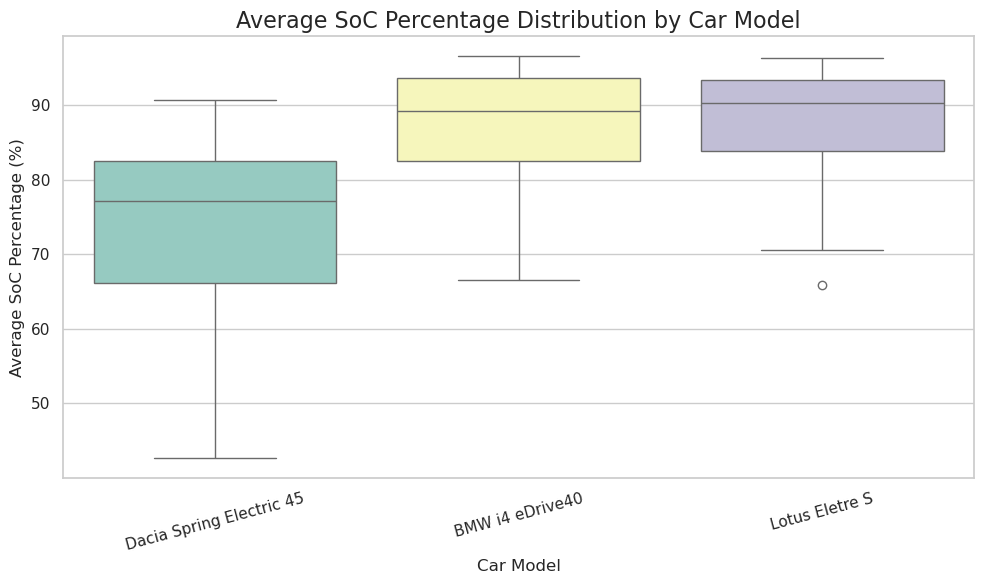

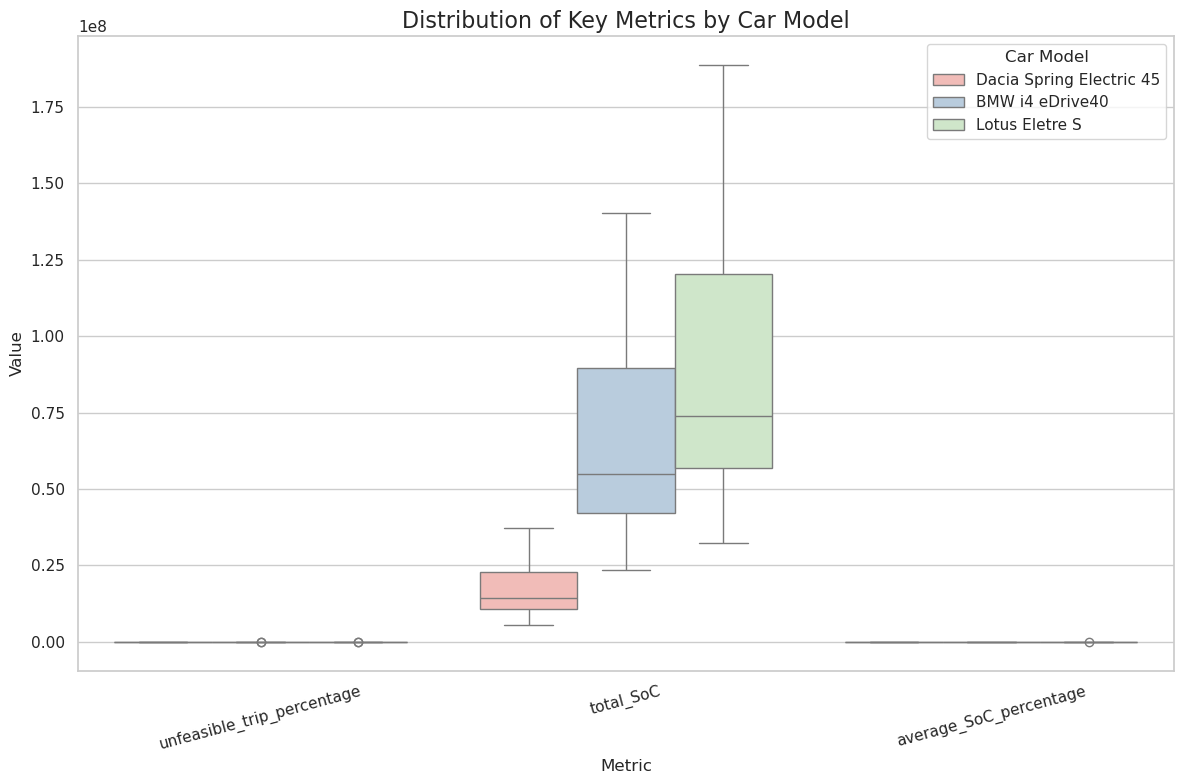

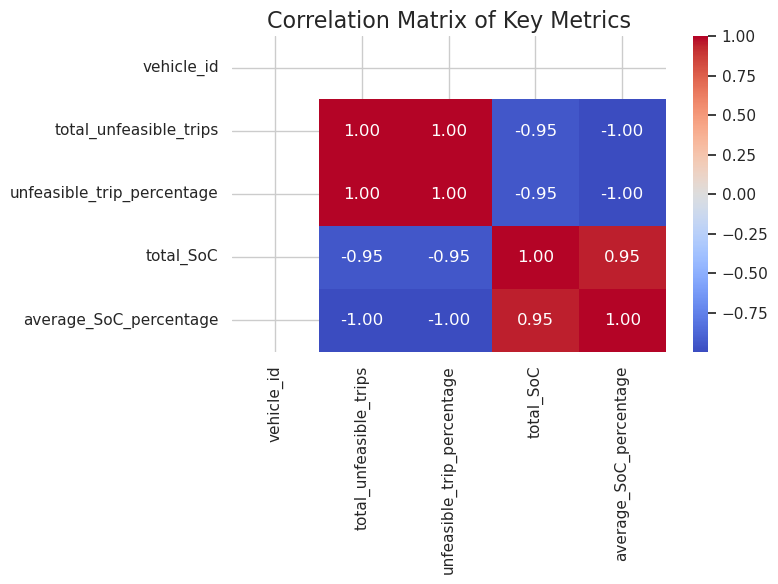

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os



# Load the simulation results data
data = pd.read_csv(r"EV_SIMULATION_RESULTS.csv")


# Set plot style
sns.set_theme(style="whitegrid")

# Visualize Unfeasible Trips vs. Car Models
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data,
    x="car_model",
    y="unfeasible_trip_percentage",
    ci=None,
    palette="Set2"
)
plt.title("Percentage of Unfeasible Trips by Car Model", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Unfeasible Trip Percentage (%)", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualize Average SoC Percentage vs. Car Models
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=data,
    x="car_model",
    y="average_SoC_percentage",
    palette="Set3"
)
plt.title("Average SoC Percentage Distribution by Car Model", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Average SoC Percentage (%)", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Pairplot to study relationships among variables
pairplot_data = data[[
    "car_model",
    "unfeasible_trip_percentage",
    "total_SoC",
    "average_SoC_percentage"
]]
pairplot_data = pairplot_data.melt(id_vars=["car_model"], var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=pairplot_data,
    x="Metric",
    y="Value",
    hue="car_model",
    palette="Pastel1"
)
plt.title("Distribution of Key Metrics by Car Model", fontsize=16)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(title="Car Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# Correlation Analysis
correlation_data = data.groupby("car_model").mean()
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Metrics", fontsize=16)
plt.tight_layout()
plt.show()


Summary statistics:
                         total_unfeasible_trips                               \
                                          count        mean         std  min   
car_model                                                                      
BMW i4 eDrive40                            61.0   11.655738   18.193300  0.0   
Dacia Spring Electric 45                   61.0  136.131148  114.841699  9.0   
Lotus Eletre S                             61.0   13.590164   20.611790  0.0   

                                                   unfeasible_trip_percentage  \
                           25%   50%    75%    max                      count   
car_model                                                                       
BMW i4 eDrive40            0.0   2.0   18.0   84.0                       61.0   
Dacia Spring Electric 45  59.0  96.0  202.0  458.0                       61.0   
Lotus Eletre S             0.0   4.0   20.0  107.0                       61.0   

            

/tmp/ipykernel_4676/2539804278.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='car_model', y='unfeasible_trip_percentage', palette='muted')


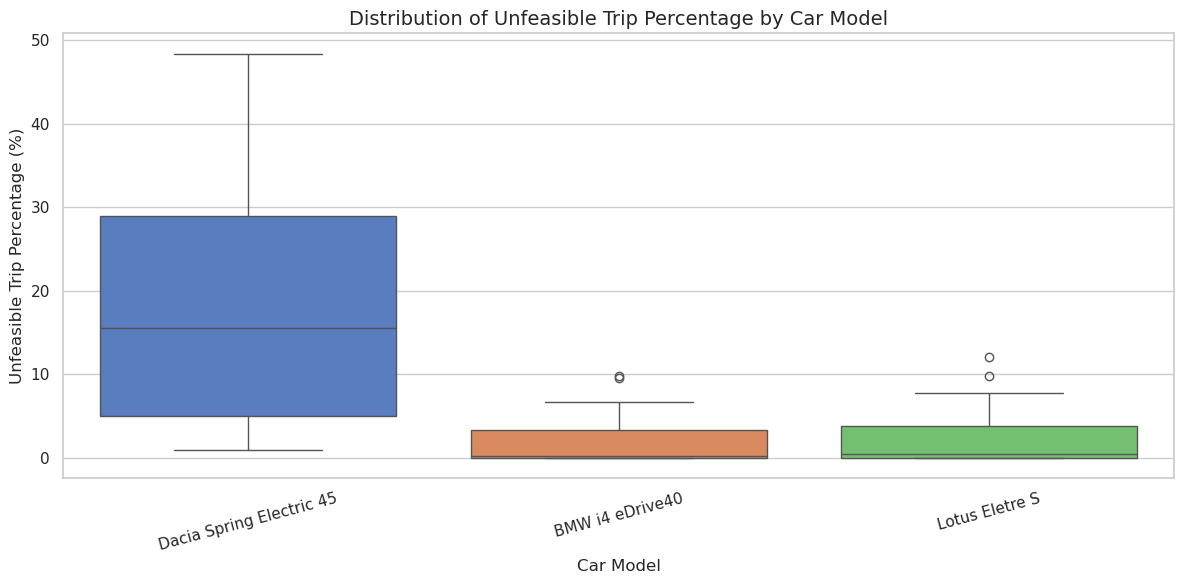

/tmp/ipykernel_4676/2539804278.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='car_model', y='average_SoC_percentage', palette='pastel')


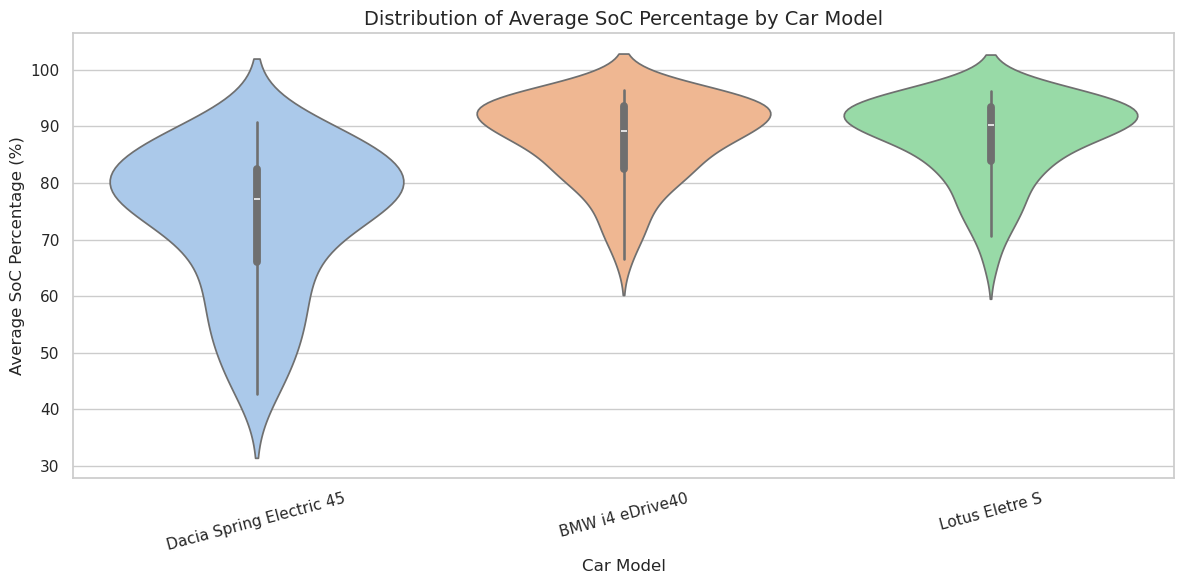

/tmp/ipykernel_4676/2539804278.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


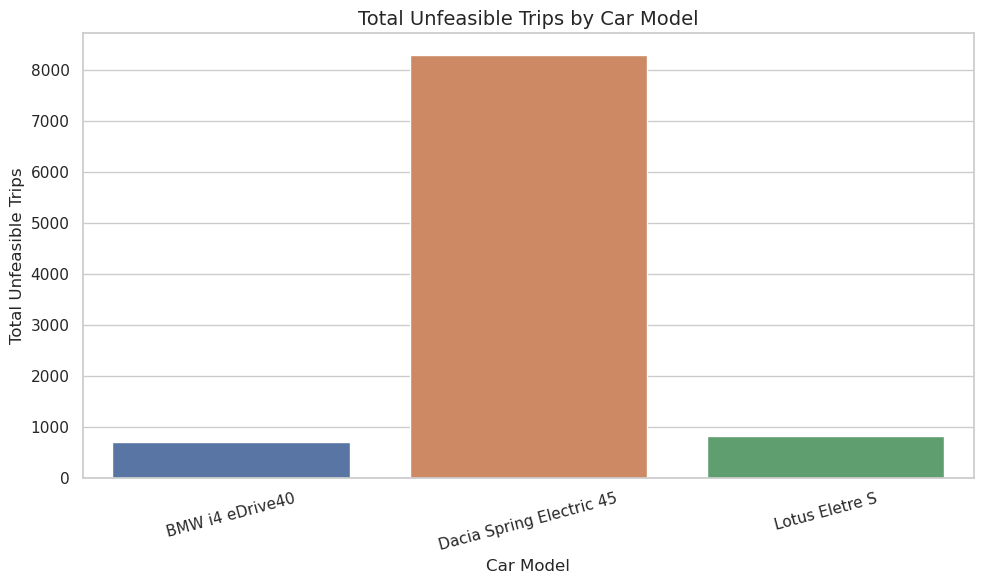

<Figure size 1200x600 with 0 Axes>

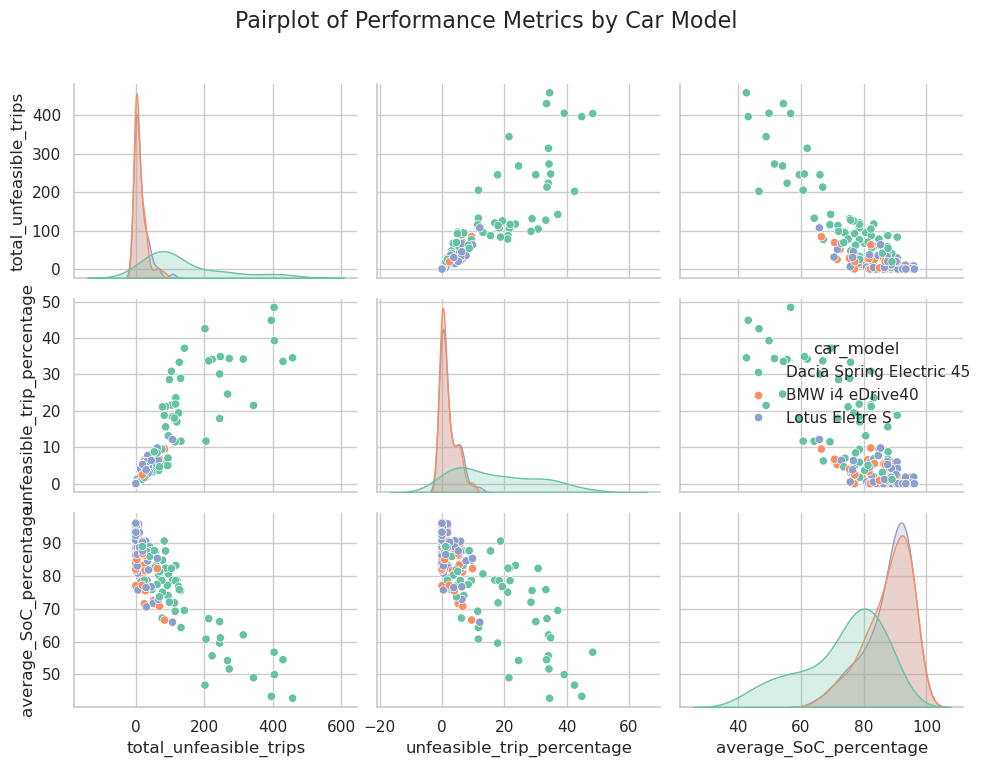

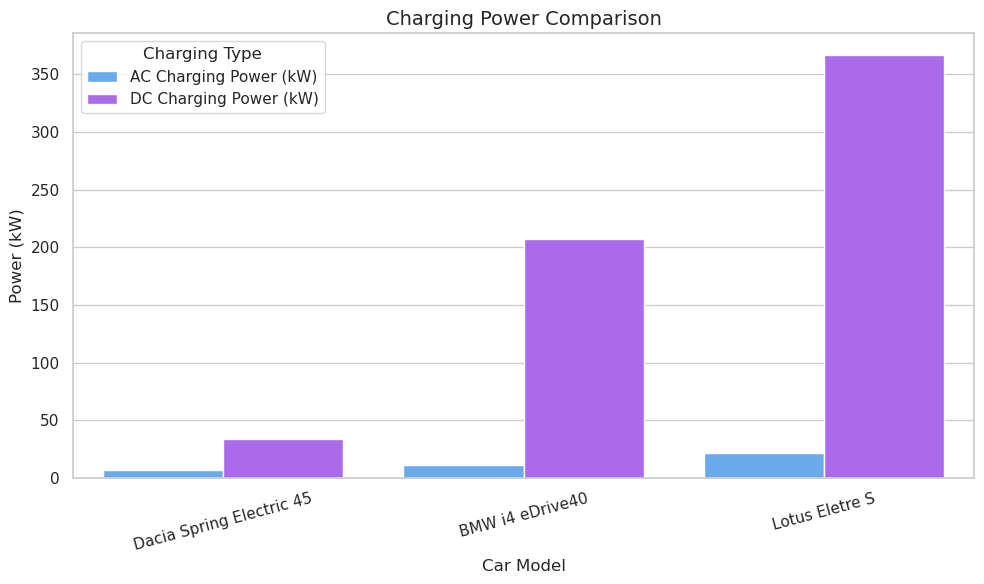

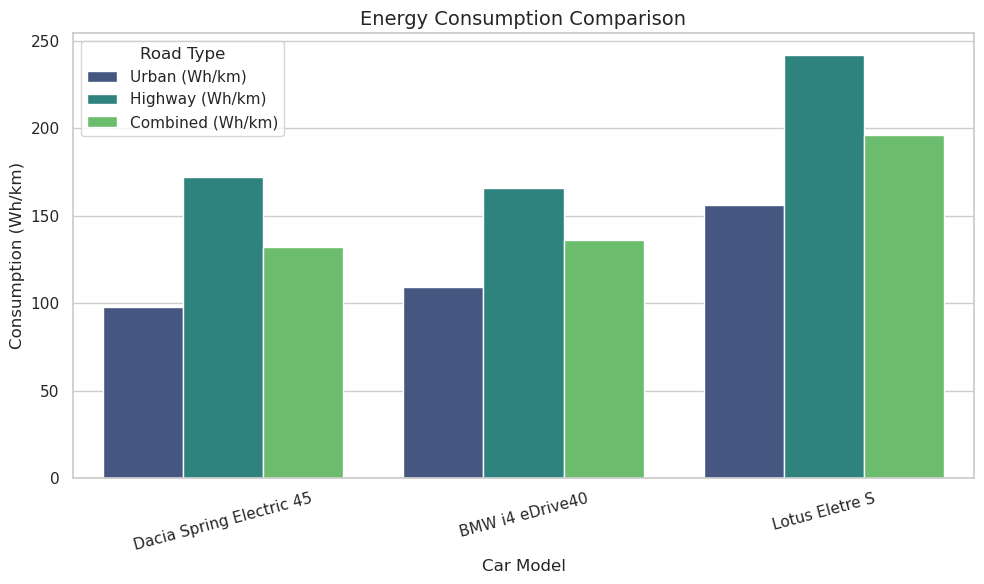

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Load simulation results
data = pd.read_csv(r"EV_SIMULATION_RESULTS.csv")

# Filter results for the selected cars
selected_cars = ["Dacia Spring Electric 45", "BMW i4 eDrive40", "Lotus Eletre S"]
data = data[data['car_model'].isin(selected_cars)]

# Summary statistics for performance metrics
summary = data.groupby('car_model')[
    ['total_unfeasible_trips', 'unfeasible_trip_percentage', 'average_SoC_percentage']
].describe()
print("Summary statistics:")
print(summary)

# Perform ANOVA tests to check differences between EV models
# 1. Unfeasible Trip Percentage
anova_unfeasible = f_oneway(
    data[data['car_model'] == "Dacia Spring Electric 45"]['unfeasible_trip_percentage'],
    data[data['car_model'] == "BMW i4 eDrive40"]['unfeasible_trip_percentage'],
    data[data['car_model'] == "Lotus Eletre S"]['unfeasible_trip_percentage']
)
print("ANOVA for Unfeasible Trip Percentage:", anova_unfeasible)

# 2. Average SoC Percentage
anova_soc = f_oneway(
    data[data['car_model'] == "Dacia Spring Electric 45"]['average_SoC_percentage'],
    data[data['car_model'] == "BMW i4 eDrive40"]['average_SoC_percentage'],
    data[data['car_model'] == "Lotus Eletre S"]['average_SoC_percentage']
)
print("ANOVA for Average SoC Percentage:", anova_soc)

# Visualization: Distribution of unfeasible trips
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='car_model', y='unfeasible_trip_percentage', palette='muted')
plt.title('Distribution of Unfeasible Trip Percentage by Car Model', fontsize=14)
plt.ylabel('Unfeasible Trip Percentage (%)', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualization: Distribution of average SoC percentage
plt.figure(figsize=(12, 6))
sns.violinplot(data=data, x='car_model', y='average_SoC_percentage', palette='pastel')
plt.title('Distribution of Average SoC Percentage by Car Model', fontsize=14)
plt.ylabel('Average SoC Percentage (%)', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualization: Total unfeasible trips per car model
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data.groupby('car_model')['total_unfeasible_trips'].sum().reset_index(),
    x='car_model',
    y='total_unfeasible_trips',
    palette='deep'
)
plt.title('Total Unfeasible Trips by Car Model', fontsize=14)
plt.ylabel('Total Unfeasible Trips', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualization: Pairplot for key metrics
plt.figure(figsize=(12, 6))
sns.pairplot(
    data,
    vars=['total_unfeasible_trips', 'unfeasible_trip_percentage', 'average_SoC_percentage'],
    hue='car_model',
    palette='Set2'
)
plt.suptitle('Pairplot of Performance Metrics by Car Model', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Additional analysis: Charging power and consumption differences
charging_power = {
    "Dacia Spring Electric 45": {"AC": 6.6, "DC": 34},
    "BMW i4 eDrive40": {"AC": 11, "DC": 207},
    "Lotus Eletre S": {"AC": 22, "DC": 367}
}

real_consumption = {
    "Dacia Spring Electric 45": {"Urban": 98, "Highway": 172, "Combined": 132},
    "BMW i4 eDrive40": {"Urban": 109, "Highway": 166, "Combined": 136},
    "Lotus Eletre S": {"Urban": 156, "Highway": 242, "Combined": 196}
}

# Convert dictionaries to DataFrames for visualization
charging_df = pd.DataFrame.from_dict(charging_power, orient='index').reset_index()
charging_df.columns = ['Car Model', 'AC Charging Power (kW)', 'DC Charging Power (kW)']

consumption_df = pd.DataFrame.from_dict(real_consumption, orient='index').reset_index()
consumption_df.columns = ['Car Model', 'Urban (Wh/km)', 'Highway (Wh/km)', 'Combined (Wh/km)']

# Plot Charging Power
charging_df_melted = charging_df.melt(id_vars=['Car Model'], var_name='Charging Type', value_name='Power (kW)')
plt.figure(figsize=(10, 6))
sns.barplot(data=charging_df_melted, x='Car Model', y='Power (kW)', hue='Charging Type', palette='cool')
plt.title('Charging Power Comparison', fontsize=14)
plt.ylabel('Power (kW)', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Charging Type')
plt.tight_layout()
plt.show()

# Plot Energy Consumption
consumption_df_melted = consumption_df.melt(id_vars=['Car Model'], var_name='Road Type', value_name='Consumption (Wh/km)')
plt.figure(figsize=(10, 6))
sns.barplot(data=consumption_df_melted, x='Car Model', y='Consumption (Wh/km)', hue='Road Type', palette='viridis')
plt.title('Energy Consumption Comparison', fontsize=14)
plt.ylabel('Consumption (Wh/km)', fontsize=12)
plt.xlabel('Car Model', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Road Type')
plt.tight_layout()
plt.show()


  d. If slow AC charging is performed, how the performance change with respect to fast DC
charging?


In [24]:
import pandas as pd

# Load the reformatted trips data
data = pd.read_csv(r"REFORMATTED_TRIPS.csv")

# Convert start_time and stop_time to datetime for calculations
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Define EV cars and performance metrics
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "AC": {
            "Charge Power": 6.6,  # kW
            "Charge Speed": 37  # km/h
        },
        "DC": {
            "Charge Power (max)": 34,  # kW
            "Charge Speed": 180  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 98,  # Wh/km
            "Highway": 172,  # Wh/km
            "Combined": 132  # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "AC": {
            "Charge Power": 11,  # kW
            "Charge Speed": 60  # km/h
        },
        "DC": {
            "Charge Power (max)": 207,  # kW
            "Charge Speed": 800  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 109,  # Wh/km
            "Highway": 166,  # Wh/km
            "Combined": 136  # Wh/km
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "AC": {
            "Charge Power": 22,  # kW
            "Charge Speed": 82  # km/h
        },
        "DC": {
            "Charge Power (max)": 367,  # kW
            "Charge Speed": 1060  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 156,  # Wh/km
            "Highway": 242,  # Wh/km
            "Combined": 196  # Wh/km
        }
    }
}

def simulate_vehicle(vehicle_data, car_specs, charging_type="AC"):
    """Simulate the behavior of a vehicle using a specific EV model and charging type."""
    SoC = car_specs["Useable Capacity"] * 1000  # Convert kWh to Wh
    total_unfeasible_trips = 0
    total_trips = 0
    total_SoC = 0

    for _, trip in vehicle_data.iterrows():
        total_trips += 1
        road_type = trip["road"]
        distance = trip["total_distance"]  # km

        # Determine energy consumption based on road type
        if road_type == "U":
            consumption_per_km = car_specs["Real_energy_consumption"]["Urban"]
        elif road_type == "A":
            consumption_per_km = car_specs["Real_energy_consumption"]["Highway"]
        else:  # Combined for other cases (E and unknown)
            consumption_per_km = car_specs["Real_energy_consumption"]["Combined"]

        energy_required = consumption_per_km * distance  # in Wh

        # Check if the trip is feasible
        if SoC >= energy_required:
            SoC -= energy_required
        else:
            total_unfeasible_trips += 1
            SoC = 0  # Assume arrival with 0% SoC

        # Simulate charging during pause time if applicable
        pause_time = trip["pause_time_minutes"]  # in minutes
        if pd.notnull(pause_time) and pause_time >= 20:
            if charging_type == "AC":
                charge_power = car_specs["AC"]["Charge Power"] * 60  # Wh per minute
            elif charging_type == "DC":
                charge_power = car_specs["DC"]["Charge Power (max)"] * 60  # Wh per minute
            else:
                raise ValueError("Invalid charging type specified. Use 'AC' or 'DC'.")

            SoC += charge_power * pause_time
            SoC = min(SoC, car_specs["Useable Capacity"] * 1000)  # Cap at max capacity

        total_SoC += SoC

    unfeasible_percentage = (total_unfeasible_trips / total_trips) * 100
    average_SoC = total_SoC / total_trips if total_trips > 0 else 0

    return {
        "Unfeasible_trips": {
            "total": total_unfeasible_trips,
            "percentage": unfeasible_percentage
        },
        "Battery_average_SoC": {
            "total": total_SoC,
            "percentage": average_SoC / (car_specs["Useable Capacity"] * 1000) * 100
        }
    }

# Run the simulation for each vehicle and car model
results = []
for vehicle_id, vehicle_data in data.groupby("vehicle_id"):
    for car_name, car_specs in cars.items():
        # Simulation for AC charging
        ac_result = simulate_vehicle(vehicle_data, car_specs, charging_type="AC")
        # Simulation for DC charging
        dc_result = simulate_vehicle(vehicle_data, car_specs, charging_type="DC")

        results.append({
            "vehicle_id": vehicle_id,
            "car_model": car_name,
            "total_unfeasible_trips_ac": ac_result["Unfeasible_trips"]["total"],
            "unfeasible_trip_percentage_ac": ac_result["Unfeasible_trips"]["percentage"],
            "total_SoC_ac": ac_result["Battery_average_SoC"]["total"],
            "average_SoC_percentage_ac": ac_result["Battery_average_SoC"]["percentage"],
            "total_unfeasible_trips_dc": dc_result["Unfeasible_trips"]["total"],
            "unfeasible_trip_percentage_dc": dc_result["Unfeasible_trips"]["percentage"],
            "total_SoC_dc": dc_result["Battery_average_SoC"]["total"],
            "average_SoC_percentage_dc": dc_result["Battery_average_SoC"]["percentage"]
        })

# Convert results to a DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv(r"EV_SIMULATION_RESULTS_AC_vs_DC.csv", index=False)
print(results_df.head())


   vehicle_id                 car_model  total_unfeasible_trips_ac  \
0           1  Dacia Spring Electric 45                         95   
1           1           BMW i4 eDrive40                          9   
2           1            Lotus Eletre S                          8   
3           2  Dacia Spring Electric 45                        117   
4           2           BMW i4 eDrive40                         17   

   unfeasible_trip_percentage_ac  total_SoC_ac  average_SoC_percentage_ac  \
0                      13.139696  1.458164e+07                  80.672959   
1                       1.244813  5.392986e+07                  92.430967   
2                       1.106501  7.306814e+07                  92.717826   
3                      23.588710  1.032290e+07                  83.249231   
4                       3.427419  3.524740e+07                  88.058621   

   total_unfeasible_trips_dc  unfeasible_trip_percentage_dc  total_SoC_dc  \
0                         92           

In [25]:
import pandas as pd

# Load the reformatted trips data
data = pd.read_csv(r"REFORMATTED_TRIPS.csv")

# Convert start_time and stop_time to datetime for calculations
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Define EV cars and performance metrics
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "AC": {
            "Charge Power": 6.6,  # kW
            "Charge Speed": 37  # km/h
        },
        "DC": {
            "Charge Power (max)": 34,  # kW
            "Charge Speed": 180  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 98,  # Wh/km
            "Highway": 172,  # Wh/km
            "Combined": 132  # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "AC": {
            "Charge Power": 11,  # kW
            "Charge Speed": 60  # km/h
        },
        "DC": {
            "Charge Power (max)": 207,  # kW
            "Charge Speed": 800  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 109,  # Wh/km
            "Highway": 166,  # Wh/km
            "Combined": 136  # Wh/km
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "AC": {
            "Charge Power": 22,  # kW
            "Charge Speed": 82  # km/h
        },
        "DC": {
            "Charge Power (max)": 367,  # kW
            "Charge Speed": 1060  # km/h
        },
        "Real_energy_consumption": {
            "Urban": 156,  # Wh/km
            "Highway": 242,  # Wh/km
            "Combined": 196  # Wh/km
        }
    }
}

performance_metrics_to_track = {
    "Unfeasible_trips": {
        "total": 0,
        "percentage": 0.0
    },
    "Battery_average_SoC": {
        "total": 0.0,
        "percentage": 0.0
    }
}

def simulate_vehicle(vehicle_data, car_specs):
    """Simulate the behavior of a vehicle using a specific EV model."""
    SoC = car_specs["Useable Capacity"] * 1000  # Convert kWh to Wh
    total_unfeasible_trips = 0
    total_trips = 0
    total_SoC = 0

    for _, trip in vehicle_data.iterrows():
        total_trips += 1
        road_type = trip["road"]
        distance = trip["total_distance"]  # km

        # Determine energy consumption based on road type
        if road_type == "U":
            consumption_per_km = car_specs["Real_energy_consumption"]["Urban"]
        elif road_type == "A":
            consumption_per_km = car_specs["Real_energy_consumption"]["Highway"]
        else:  # Combined for other cases (E and unknown)
            consumption_per_km = car_specs["Real_energy_consumption"]["Combined"]

        energy_required = consumption_per_km * distance  # in Wh

        # Check if the trip is feasible
        if SoC >= energy_required:
            SoC -= energy_required
        else:
            total_unfeasible_trips += 1
            SoC = 0  # Assume arrival with 0% SoC

        # Simulate charging during pause time if applicable
        pause_time = trip["pause_time_minutes"]  # in minutes
        if pd.notnull(pause_time) and pause_time >= 20:
            charge_power = car_specs["DC"]["Charge Power (max)"] * 60  # Wh per minute
            SoC += charge_power * pause_time
            SoC = min(SoC, car_specs["Useable Capacity"] * 1000)  # Cap at max capacity

        total_SoC += SoC

    unfeasible_percentage = (total_unfeasible_trips / total_trips) * 100
    average_SoC = total_SoC / total_trips if total_trips > 0 else 0

    return {
        "Unfeasible_trips": {
            "total": total_unfeasible_trips,
            "percentage": unfeasible_percentage
        },
        "Battery_average_SoC": {
            "total": total_SoC,
            "percentage": average_SoC / (car_specs["Useable Capacity"] * 1000) * 100
        }
    }

# Run the simulation for each vehicle and car model
results = []
for vehicle_id, vehicle_data in data.groupby("vehicle_id"):
    for car_name, car_specs in cars.items():
        result = simulate_vehicle(vehicle_data, car_specs)
        results.append({
            "vehicle_id": vehicle_id,
            "car_model": car_name,
            "total_unfeasible_trips": result["Unfeasible_trips"]["total"],
            "unfeasible_trip_percentage": result["Unfeasible_trips"]["percentage"],
            "total_SoC": result["Battery_average_SoC"]["total"],
            "average_SoC_percentage": result["Battery_average_SoC"]["percentage"]
        })

# Convert results to a DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv(r"EV_SIMULATION_RESULTS_DC.csv", index=False)
print(results_df.head())


   vehicle_id                 car_model  total_unfeasible_trips  \
0           1  Dacia Spring Electric 45                      92   
1           1           BMW i4 eDrive40                       7   
2           1            Lotus Eletre S                       7   
3           2  Dacia Spring Electric 45                     114   
4           2           BMW i4 eDrive40                      11   

   unfeasible_trip_percentage     total_SoC  average_SoC_percentage  
0                   12.724758  1.530575e+07               84.679120  
1                    0.968188  5.485260e+07               94.012450  
2                    0.968188  7.376884e+07               93.606965  
3                   22.983871  1.109665e+07               89.489145  
4                    2.217742  3.777215e+07               94.366199  


/tmp/ipykernel_4676/3582459447.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_4676/3582459447.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


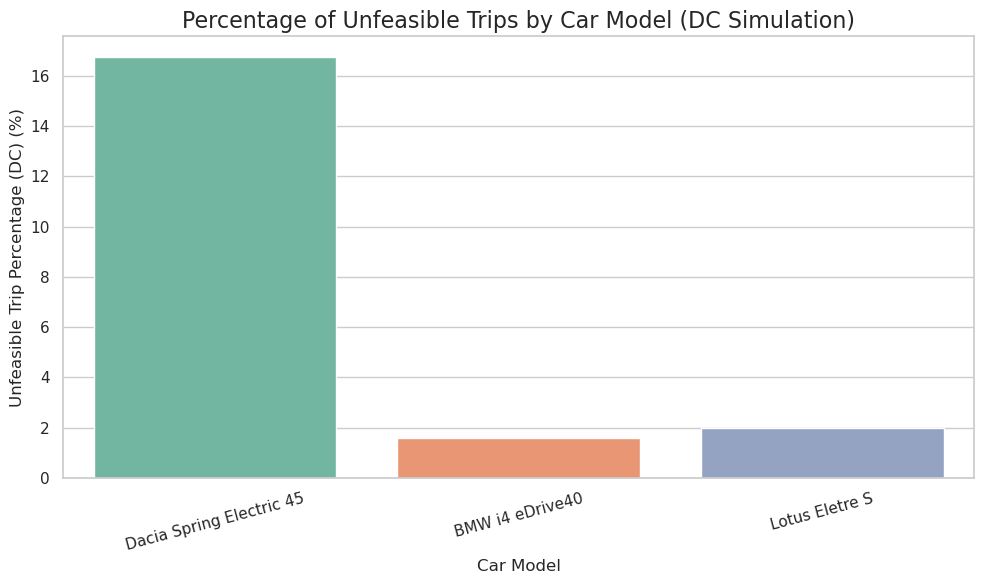

/tmp/ipykernel_4676/3582459447.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


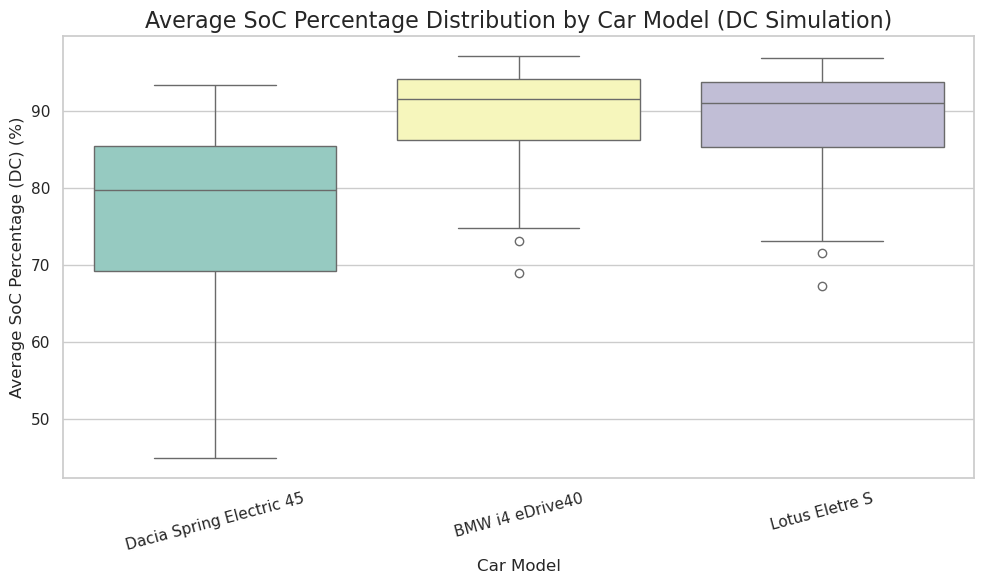

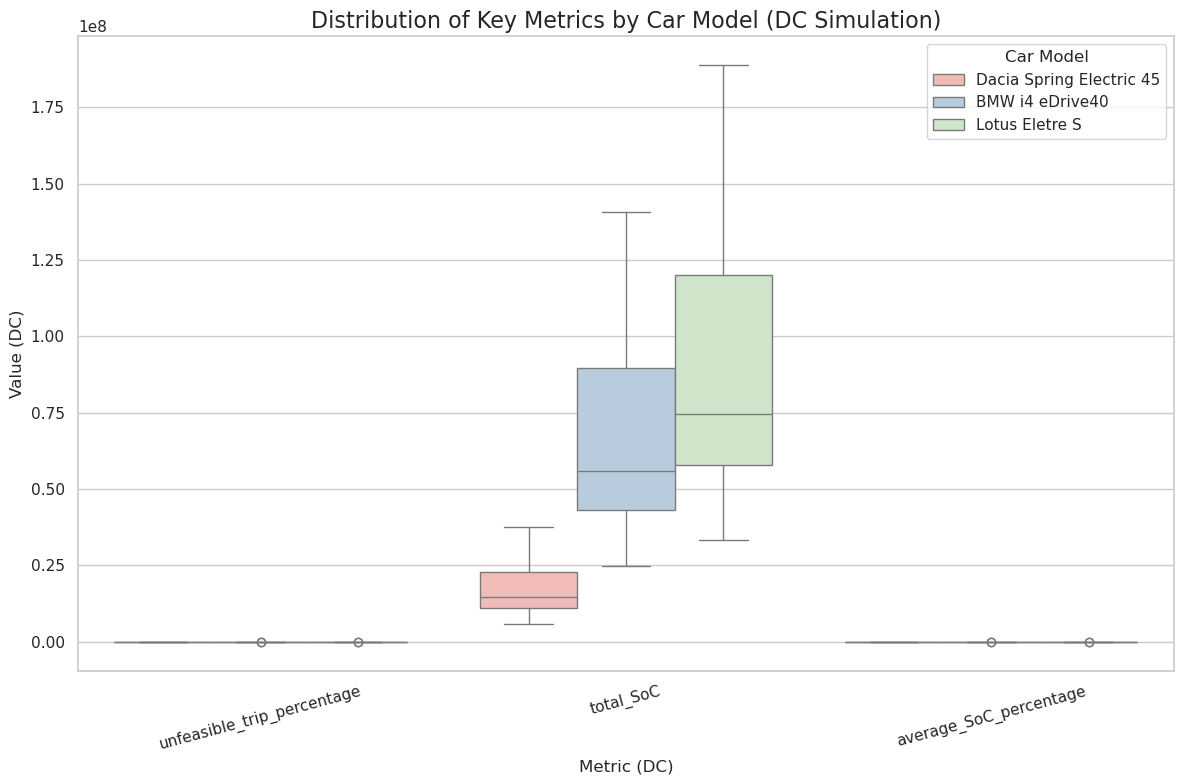

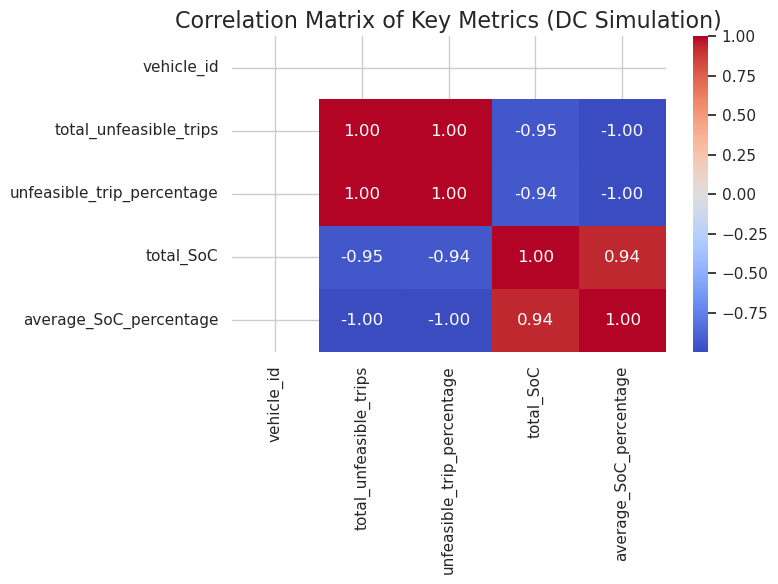

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Load the simulation results data
data = pd.read_csv(r"EV_SIMULATION_RESULTS_DC.csv")

# Set plot style
sns.set_theme(style="whitegrid")

# Visualize Unfeasible Trips vs. Car Models
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data,
    x="car_model",
    y="unfeasible_trip_percentage",
    ci=None,
    palette="Set2"
)
plt.title("Percentage of Unfeasible Trips by Car Model (DC Simulation)", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Unfeasible Trip Percentage (DC) (%)", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Visualize Average SoC Percentage vs. Car Models
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=data,
    x="car_model",
    y="average_SoC_percentage",
    palette="Set3"
)
plt.title("Average SoC Percentage Distribution by Car Model (DC Simulation)", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Average SoC Percentage (DC) (%)", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Pairplot to study relationships among variables
pairplot_data = data[[
    "car_model",
    "unfeasible_trip_percentage",
    "total_SoC",
    "average_SoC_percentage"
]]
pairplot_data = pairplot_data.melt(id_vars=["car_model"], var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=pairplot_data,
    x="Metric",
    y="Value",
    hue="car_model",
    palette="Pastel1"
)
plt.title("Distribution of Key Metrics by Car Model (DC Simulation)", fontsize=16)
plt.xlabel("Metric (DC)", fontsize=12)
plt.ylabel("Value (DC)", fontsize=12)
plt.legend(title="Car Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# Correlation Analysis
correlation_data = data.groupby("car_model").mean()
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Metrics (DC Simulation)", fontsize=16)
plt.tight_layout()
plt.show()



  e. Report and comment the difference in performance among the clusters of vehicles found at
step 1.

Colonne nel dataset originale:
['vehicle_id', 'date', 'road', 'day_type', 'total_distance', 'driving_time', 'num_trips', 'daily_utilization']


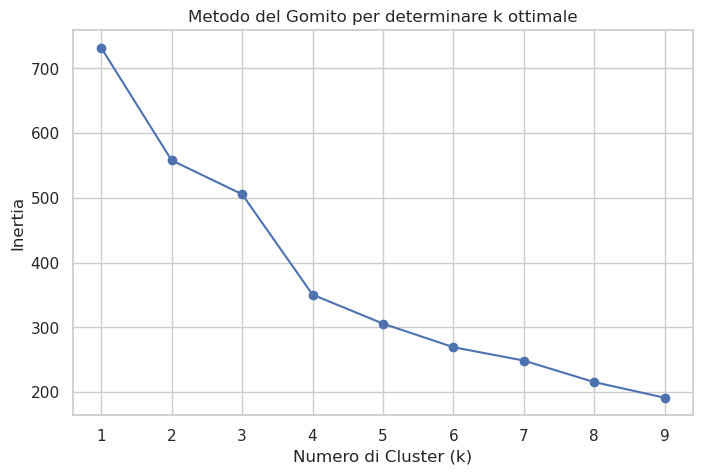

Cluster Summary:
         total_distance_A  total_distance_E  total_distance_U  \
Cluster                                                         
0             3848.221071       5997.483929       6803.015357   
1             5450.241111       7052.071889       7530.904444   
2            19949.670261       5960.558826       1383.596783   
3                0.000000          0.000000          0.000000   

         total_distance__  daily_utilization_A  daily_utilization_E  \
Cluster                                                               
0                0.953929             0.694829             0.637181   
1                2.093333             0.877111             0.880334   
2              339.983913             0.975420             0.906452   
3            16792.620000             0.000000             0.000000   

         daily_utilization_U  daily_utilization__  num_trips_A  num_trips_E  \
Cluster                                                                       
0      

In [27]:
# Importazione delle librerie necessarie
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Caricamento del dataset
data = pd.read_csv("Unipol_dataset_aggregated_and_filtered.csv")

# Verifica delle colonne presenti nel dataset originale
print("Colonne nel dataset originale:")
print(data.columns.tolist())

# Aggregazione dei dati per vehicle_id e road includendo 'num_trips'
aggregated_data = data.groupby(['vehicle_id', 'road']).agg({
    'total_distance': 'sum',
    'daily_utilization': 'mean',
    'num_trips': 'sum'  # Inclusione di 'num_trips'
}).unstack(fill_value=0)

# Appiattimento delle colonne MultiIndex
aggregated_data.columns = [f"{col[0]}_{col[1]}" for col in aggregated_data.columns]
aggregated_data.reset_index(inplace=True)

# Selezione delle feature rilevanti per il clustering
road_features = [col for col in aggregated_data.columns if 'total_distance' in col]
utilization_feature = [col for col in aggregated_data.columns if 'daily_utilization' in col]
trip_feature = [col for col in aggregated_data.columns if 'num_trips' in col]
features = road_features + utilization_feature + trip_feature
selected_data = aggregated_data[features]

# Normalizzazione dei dati per il clustering
scaler = StandardScaler()
normalized_data = scaler.fit_transform(selected_data)

# Determinazione del numero ottimale di cluster usando il Metodo del Gomito
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Tracciamento della curva del gomito
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Inertia')
plt.title('Metodo del Gomito per determinare k ottimale')
plt.show()

# Scelta del numero di cluster (ad esempio, 4 basato sul gomito)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Aggiunta delle etichette di cluster al dataset aggregato
aggregated_data['Cluster'] = clusters

# Analisi dei cluster basata sull'uso delle strade, la daily utilization e i num_trips
cluster_summary = aggregated_data.groupby('Cluster')[features].mean()
print("Cluster Summary:")
print(cluster_summary)

# Salvataggio del nuovo dataset clusterizzato
aggregated_data.to_csv("clustered_vehicles1.csv", index=False)

# Visualizzazione dei cluster usando pairplot (per set di feature più piccoli)
if len(features) <= 5:
    sns.pairplot(aggregated_data, vars=features, hue='Cluster', palette='tab10')
    plt.title('Visualizzazione dei Cluster')
    plt.show()


Nomi delle colonne nel dataset clusterizzato:
['vehicle_id', 'total_distance_A', 'total_distance_E', 'total_distance_U', 'total_distance__', 'daily_utilization_A', 'daily_utilization_E', 'daily_utilization_U', 'daily_utilization__', 'num_trips_A', 'num_trips_E', 'num_trips_U', 'num_trips__', 'Cluster']

Performance Metrics per Cluster e Modello EV:
+-----------+--------------------------+-----------------------------+------------------------+
|   Cluster | EV_Model                 |   Total_Energy_Required_kWh |   Battery_Capacity_kWh |
+===========+==========================+=============================+========================+
|         0 | Dacia Spring Electric 45 |                     2120.38 |                   25   |
+-----------+--------------------------+-----------------------------+------------------------+
|         0 | BMW i4 eDrive40          |                     2196.12 |                   80.7 |
+-----------+--------------------------+-----------------------------+---

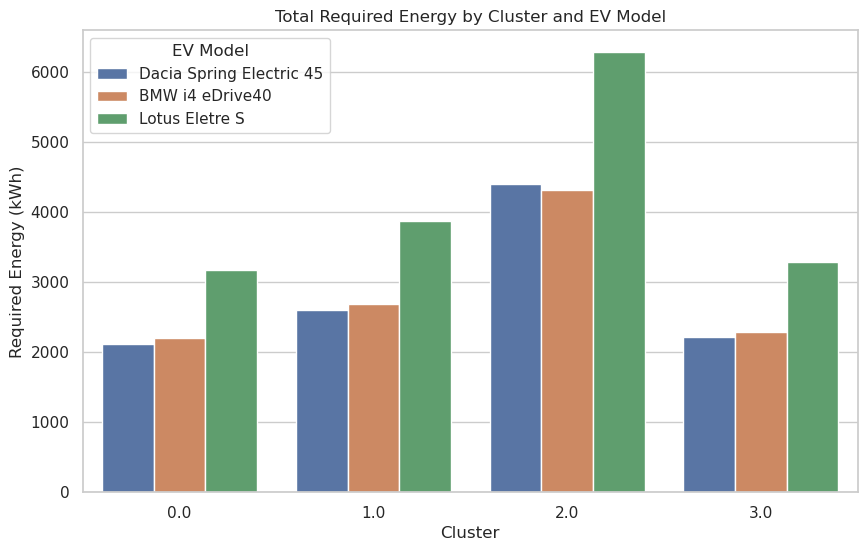

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

# Definizione dei modelli EV
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "Real_energy_consumption": {
            "City": 98,  # Wh/km
            "Highway": 172,  # Wh/km
            "Combined": 132  # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "Real_energy_consumption": {
            "City": 109,  # Wh/km
            "Highway": 166,  # Wh/km
            "Combined": 136  # Wh/km
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "Real_energy_consumption": {
            "City": 156,  # Wh/km
            "Highway": 242,  # Wh/km
            "Combined": 196  # Wh/km
        }
    }
}

# Mapping dei tipi di strada ai consumi energetici
road_type_mapping = {
    "A": "Highway",
    "E": "Combined",  # Assumendo "E" come Extra-Urban simile al Combined
    "U": "City",
    "_": "Combined"  # Trattando "_" come Combined
}

# Caricamento del dataset clusterizzato
clustered_data = pd.read_csv("clustered_vehicles1.csv")

# Visualizza i nomi delle colonne per conferma
print("Nomi delle colonne nel dataset clusterizzato:")
print(clustered_data.columns.tolist())

# Calcolo delle statistiche medie per ciascun cluster
cluster_stats = clustered_data.groupby('Cluster').agg({
    'total_distance_A': 'mean',
    'total_distance_E': 'mean',
    'total_distance_U': 'mean',
    'total_distance__': 'mean',
    'daily_utilization_A': 'mean',
    'daily_utilization_E': 'mean',
    'daily_utilization_U': 'mean',
    'daily_utilization__': 'mean',
    'num_trips_A': 'sum',
    'num_trips_E': 'sum',
    'num_trips_U': 'sum',
    'num_trips__': 'sum'
}).reset_index()

# Calcolo della somma totale dei viaggi per ciascun cluster
cluster_stats['total_num_trips'] = (
    cluster_stats['num_trips_A'] +
    cluster_stats['num_trips_E'] +
    cluster_stats['num_trips_U'] +
    cluster_stats['num_trips__']
)

# Calcolo della distanza totale e media per viaggio
cluster_stats['total_distance'] = (
    cluster_stats['total_distance_A'] +
    cluster_stats['total_distance_E'] +
    cluster_stats['total_distance_U'] +
    cluster_stats['total_distance__']
)
cluster_stats['avg_distance_per_trip'] = cluster_stats['total_distance'] / cluster_stats['total_num_trips']

# Definizione delle metriche di prestazione
performance_metrics = []  # Inizializzazione della lista vuota

# Funzione per calcolare l'energia richiesta in base al consumo
def calculate_energy_required(row, car_consumption):
    energy_city = row['total_distance_U'] * car_consumption['City'] / 1000  # kWh
    energy_highway = row['total_distance_A'] * car_consumption['Highway'] / 1000  # kWh
    energy_combined = (row['total_distance_E'] + row['total_distance__']) * car_consumption['Combined'] / 1000  # kWh
    total_energy = energy_city + energy_highway + energy_combined
    return total_energy

# Iterazione su ciascun cluster e su ciascun modello EV
for index, cluster in cluster_stats.iterrows():
    for ev_model, ev_specs in cars.items():
        # Calcolo dell'energia totale richiesta
        total_energy_required = calculate_energy_required(cluster, ev_specs['Real_energy_consumption'])

        # Capacità della batteria
        battery_capacity = ev_specs['Useable Capacity']

        # Calcolo dello stato di carica medio (SoC)
        average_soc = max((battery_capacity - total_energy_required) / battery_capacity * 100, 0)

        # Calcolo della distanza massima per viaggio
        # Utilizziamo il consumo maggiore (Highway) per essere conservativi
        max_trip_distance = battery_capacity * 1000 / ev_specs['Real_energy_consumption']['Highway']  # km

        # Calcolo del numero di viaggi non fattibili
        avg_distance_per_trip = cluster['avg_distance_per_trip']
        total_num_trips = cluster['total_num_trips']
        unfeasible_trips = total_num_trips if avg_distance_per_trip > max_trip_distance else 0
        unfeasible_trips_percentage = (unfeasible_trips / total_num_trips) * 100 if total_num_trips > 0 else 0

        # Aggiunta dei dati alla lista delle metriche
        performance_metrics.append({
            'Cluster': cluster['Cluster'],
            'EV_Model': ev_model,
            'Total_Energy_Required_kWh': round(total_energy_required, 2),
            'Battery_Capacity_kWh': battery_capacity,
            'Unfeasible_Trips': int(unfeasible_trips),
            'Unfeasible_Trips_Percentage': round(unfeasible_trips_percentage, 2),
            'Average_SoC_Percentage': round(average_soc, 2)
        })

# Creazione del DataFrame finale dalle metriche raccolte
performance_metrics_df = pd.DataFrame(performance_metrics)

# Riordino delle colonne per una migliore leggibilità
performance_metrics_df = performance_metrics_df[[
    'Cluster',
    'EV_Model',
    'Total_Energy_Required_kWh',
    'Battery_Capacity_kWh',

]]

# Stampa delle metriche di prestazione in una tabella ben formattata
print("\nPerformance Metrics per Cluster e Modello EV:")
print(tabulate(performance_metrics_df, headers='keys', tablefmt='grid', showindex=False))

# Analisi e commento delle differenze nelle prestazioni tra i cluster
for cluster in performance_metrics_df['Cluster'].unique():
    cluster_data = performance_metrics_df[performance_metrics_df['Cluster'] == cluster]
    print(f"\n--- Cluster {int(cluster)} ---")
    for _, row in cluster_data.iterrows():
        print(f"Modello EV: {row['EV_Model']}")
        print(f"  Energia Totale Richiesta: {row['Total_Energy_Required_kWh']} kWh")
        print(f"  Capacità Batteria: {row['Battery_Capacity_kWh']} kWh")

# Visualizzazione dei risultati con grafici

# Grafico : Energia Totale Richiesta vs Cluster per ciascun EV
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Total_Energy_Required_kWh', hue='EV_Model', data=performance_metrics_df)
plt.title('Total Required Energy by Cluster and EV Model')
plt.xlabel('Cluster')
plt.ylabel('Required Energy (kWh)')
plt.legend(title='EV Model')
plt.show()



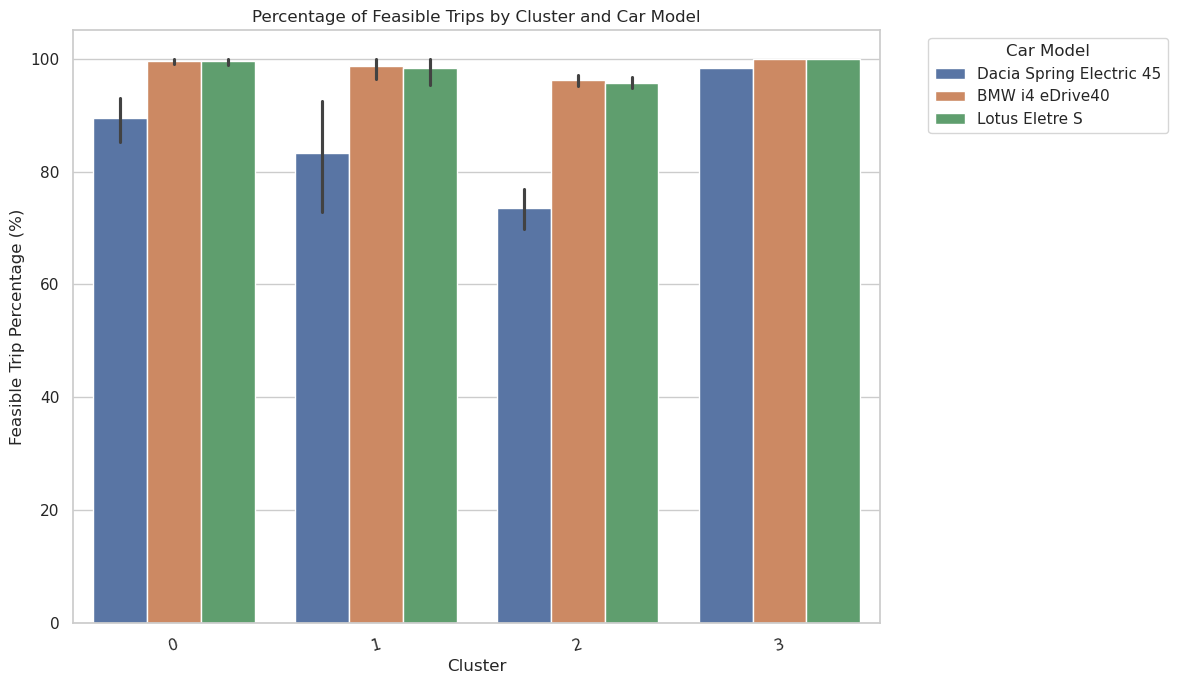

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data from both CSV files
unfeasible_trips_data = pd.read_csv('UNFEASIBLE_TRIPS_ANALYSIS.csv')
clustered_data = pd.read_csv('clustered_vehicles1.csv')

# Step 2: Merge the datasets on 'vehicle_id'
merged_data = pd.merge(unfeasible_trips_data, clustered_data, on='vehicle_id')

# Step 3: Calculate the percentage of feasible trips
merged_data['Feasible_Trips_Percentage'] = 100 - merged_data['Percentage_unfeasible']

# Step 4: Create a bar plot for percentage of feasible trips with clusters on x-axis
plt.figure(figsize=(12, 7))
sns.barplot(
    x='Cluster',
    y='Feasible_Trips_Percentage',
    hue='car_model',
    data=merged_data
)

plt.title('Percentage of Feasible Trips by Cluster and Car Model')
plt.xlabel('Cluster')
plt.ylabel('Feasible Trip Percentage (%)')
plt.xticks(rotation=15)  # Optional: Rotating x-axis labels if needed
plt.legend(title='Car Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout()  # Adjust layout for better fitting of the plot

# Display the plot
plt.show()




## 5. Estimate charging costs and EV costs and comments on the tradeoff between performance and costs.



In [30]:
import pandas as pd

# Load the reformatted trips data
data = pd.read_csv(r"REFORMATTED_TRIPS.csv")

# Convert start_time and stop_time to datetime for calculations
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Define EV cars, performance metrics, and cost-related parameters
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "AC": {
            "Charge Power": 6.6,  # kW
            "Charge Speed": 37,   # km/h
            "Cost per kWh": 0.30  # EUR/kWh
        },
        "DC": {
            "Charge Power (max)": 34,  # kW
            "Charge Speed": 180,       # km/h
            "Cost per kWh": 0.45       # EUR/kWh
        },
        "Real_energy_consumption": {
            "Urban": 98,  # Wh/km
            "Highway": 172,  # Wh/km
            "Combined": 132  # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "AC": {
            "Charge Power": 11,   # kW
            "Charge Speed": 60,   # km/h
            "Cost per kWh": 0.30  # EUR/kWh
        },
        "DC": {
            "Charge Power (max)": 207,  # kW
            "Charge Speed": 800,        # km/h
            "Cost per kWh": 0.45        # EUR/kWh
        },
        "Real_energy_consumption": {
            "Urban": 109,  # Wh/km
            "Highway": 166,  # Wh/km
            "Combined": 136  # Wh/km
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "AC": {
            "Charge Power": 22,   # kW
            "Charge Speed": 82,   # km/h
            "Cost per kWh": 0.30  # EUR/kWh
        },
        "DC": {
            "Charge Power (max)": 367,  # kW
            "Charge Speed": 1060,      # km/h
            "Cost per kWh": 0.45       # EUR/kWh
        },
        "Real_energy_consumption": {
            "Urban": 156,  # Wh/km
            "Highway": 242,  # Wh/km
            "Combined": 196  # Wh/km
        }
    }
}

def simulate_vehicle_with_cost(vehicle_data, car_specs):
    """Simulate the behavior of a vehicle and estimate charging costs."""
    SoC = car_specs["Useable Capacity"] * 1000  # Convert kWh to Wh
    total_unfeasible_trips = 0
    total_trips = 0
    total_SoC = 0
    total_cost_AC = 0.0
    total_cost_DC = 0.0

    for _, trip in vehicle_data.iterrows():
        total_trips += 1
        road_type = trip["road"]
        distance = trip["total_distance"]  # km

        # Determine energy consumption based on road type
        if road_type == "U":
            consumption_per_km = car_specs["Real_energy_consumption"]["Urban"]
        elif road_type == "A":
            consumption_per_km = car_specs["Real_energy_consumption"]["Highway"]
        else:  # Combined for other cases (E and unknown)
            consumption_per_km = car_specs["Real_energy_consumption"]["Combined"]

        energy_required = consumption_per_km * distance  # in Wh

        # Check if the trip is feasible
        if SoC >= energy_required:
            SoC -= energy_required
        else:
            total_unfeasible_trips += 1
            SoC = 0  # Assume arrival with 0% SoC

        # Simulate charging during pause time if applicable
        pause_time = trip["pause_time_minutes"]  # in minutes
        if pd.notnull(pause_time) and pause_time >= 20:
            charge_power_AC = car_specs["AC"]["Charge Power"] * 60  # Wh per minute
            charge_power_DC = car_specs["DC"]["Charge Power (max)"] * 60  # Wh per minute
            energy_added_AC = min(charge_power_AC * pause_time, car_specs["Useable Capacity"] * 1000 - SoC)
            energy_added_DC = min(charge_power_DC * pause_time, car_specs["Useable Capacity"] * 1000 - SoC)

            # Update SoC and costs
            SoC += energy_added_AC  # Assume AC charging
            total_cost_AC += (energy_added_AC / 1000) * car_specs["AC"]["Cost per kWh"]  # Convert Wh to kWh
            SoC = min(SoC, car_specs["Useable Capacity"] * 1000)

            SoC += energy_added_DC  # Assume DC charging
            total_cost_DC += (energy_added_DC / 1000) * car_specs["DC"]["Cost per kWh"]  # Convert Wh to kWh
            SoC = min(SoC, car_specs["Useable Capacity"] * 1000)

        total_SoC += SoC

    unfeasible_percentage = (total_unfeasible_trips / total_trips) * 100
    average_SoC = total_SoC / total_trips if total_trips > 0 else 0

    return {
        "Unfeasible_trips": {
            "total": total_unfeasible_trips,
            "percentage": unfeasible_percentage
        },
        "Battery_average_SoC": {
            "total": total_SoC,
            "percentage": average_SoC / (car_specs["Useable Capacity"] * 1000) * 100
        },
        "Charging_Costs": {
            "AC": total_cost_AC,
            "DC": total_cost_DC
        }
    }

# Run the simulation for each vehicle and car model
results = []
for vehicle_id, vehicle_data in data.groupby("vehicle_id"):
    for car_name, car_specs in cars.items():
        result = simulate_vehicle_with_cost(vehicle_data, car_specs)
        results.append({
            "vehicle_id": vehicle_id,
            "car_model": car_name,
            "total_unfeasible_trips": result["Unfeasible_trips"]["total"],
            "unfeasible_trip_percentage": result["Unfeasible_trips"]["percentage"],
            "total_SoC": result["Battery_average_SoC"]["total"],
            "average_SoC_percentage": result["Battery_average_SoC"]["percentage"],
            "charging_cost_AC": result["Charging_Costs"]["AC"],
            "charging_cost_DC": result["Charging_Costs"]["DC"]
        })

# Convert results to a DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv(r"OUTPUTS_LAB3\\EV_SIMULATION_COST_RESULTS_AC_vs_DC.csv", index=False)
print(results_df.head())



   vehicle_id                 car_model  total_unfeasible_trips  \
0           1  Dacia Spring Electric 45                      92   
1           1           BMW i4 eDrive40                       7   
2           1            Lotus Eletre S                       7   
3           2  Dacia Spring Electric 45                     114   
4           2           BMW i4 eDrive40                      11   

   unfeasible_trip_percentage     total_SoC  average_SoC_percentage  \
0                   12.724758  1.530575e+07               84.679120   
1                    0.968188  5.485260e+07               94.012450   
2                    0.968188  7.376884e+07               93.606965   
3                   22.983871  1.109665e+07               89.489145   
4                    2.217742  3.777215e+07               94.366199   

   charging_cost_AC  charging_cost_DC  
0        757.966256       1363.747837  
1       1017.232865       1790.016181  
2       1571.870608       2584.199714  
3        8

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the simulation results
results_df = pd.read_csv(r"EV_SIMULATION_COST_RESULTS_AC_vs_DC.csv")

# Calculate summary statistics
summary_stats = results_df.groupby("car_model")[["charging_cost_AC", "charging_cost_DC"]].agg(["mean", "std", "min", "max"])

# Print summary statistics
print("Summary Statistics:")
print(summary_stats)

# Plot 1: Total charging cost comparison (AC vs DC) by car model
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="car_model", value_vars=["charging_cost_AC", "charging_cost_DC"]),
            x="car_model", y="value", hue="variable", palette="viridis")
plt.title("Total Charging Costs Comparison (AC vs DC) by Car Model")
plt.ylabel("Charging Cost (EUR)")
plt.xlabel("Car Model")
plt.legend(title="Charging Type", labels=["AC Charging", "DC Charging"])
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



# Statistical Analysis for cost comparison
cost_diff = results_df.copy()
cost_diff["Cost Difference (DC - AC)"] = cost_diff["charging_cost_DC"] - cost_diff["charging_cost_AC"]

# Plot 4: Cost difference (DC - AC) by car model
plt.figure(figsize=(8, 5))
sns.boxplot(data=cost_diff, x="car_model", y="Cost Difference (DC - AC)", palette="Pastel1")
plt.title("Cost Difference (DC - AC) by Car Model")
plt.ylabel("Cost Difference (EUR)")
plt.xlabel("Car Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Print additional statistics for cost differences
cost_diff_stats = cost_diff.groupby("car_model")["Cost Difference (DC - AC)"].agg(["mean", "std", "min", "max"])
print("\nCost Difference (DC - AC) Statistics:")
print(cost_diff_stats)


FileNotFoundError: [Errno 2] No such file or directory: 'EV_SIMULATION_COST_RESULTS_AC_vs_DC.csv'


## 6. (Optional) Using the same dataset, implement a more realistic scenario for the simulation (different policy for charging), perform the simulation and analyse the results.

   vehicle_id                 car_model  total_unfeasible_trips  \
0           1  Dacia Spring Electric 45                      96   
1           1           BMW i4 eDrive40                       7   
2           1            Lotus Eletre S                       8   
3           2  Dacia Spring Electric 45                     132   
4           2           BMW i4 eDrive40                      18   

   unfeasible_trip_percentage     total_SoC  average_SoC_percentage  \
0                   13.278008  1.337619e+07               74.003828   
1                    0.968188  5.270097e+07               90.324754   
2                    1.106501  7.119321e+07               90.338687   
3                   26.612903  9.472592e+06               76.391868   
4                    3.629032  3.524422e+07               88.050679   

   total_energy_used_kWh  AC_cost_EUR    DC_cost_EUR  Total_AC_energy_kWh  \
0            4117.878952  1007.234113   26436.034167          3357.447042   
1            406

<ipython-input-2-83ffe795dc7e>:283: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-2-83ffe795dc7e>:283: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


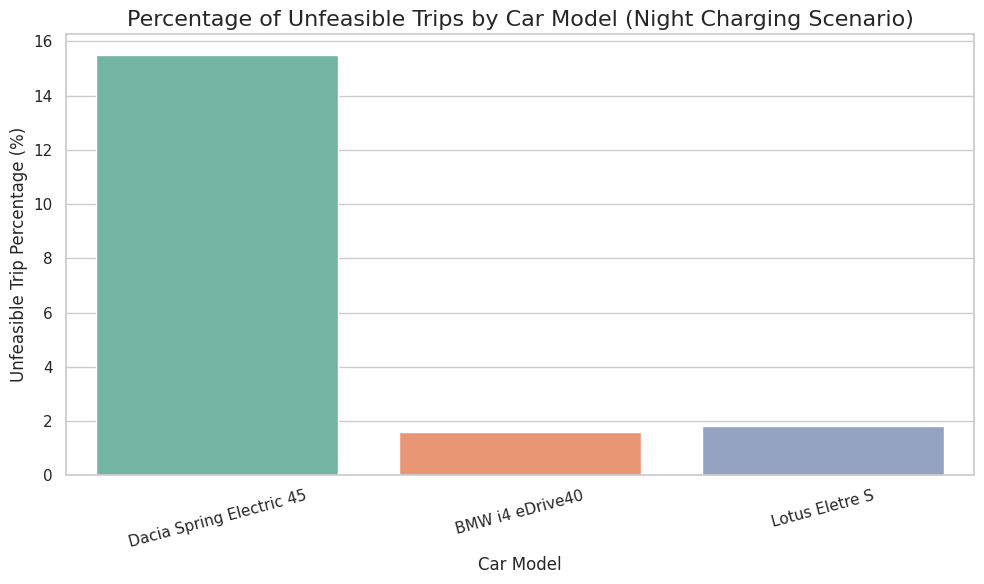

<ipython-input-2-83ffe795dc7e>:299: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


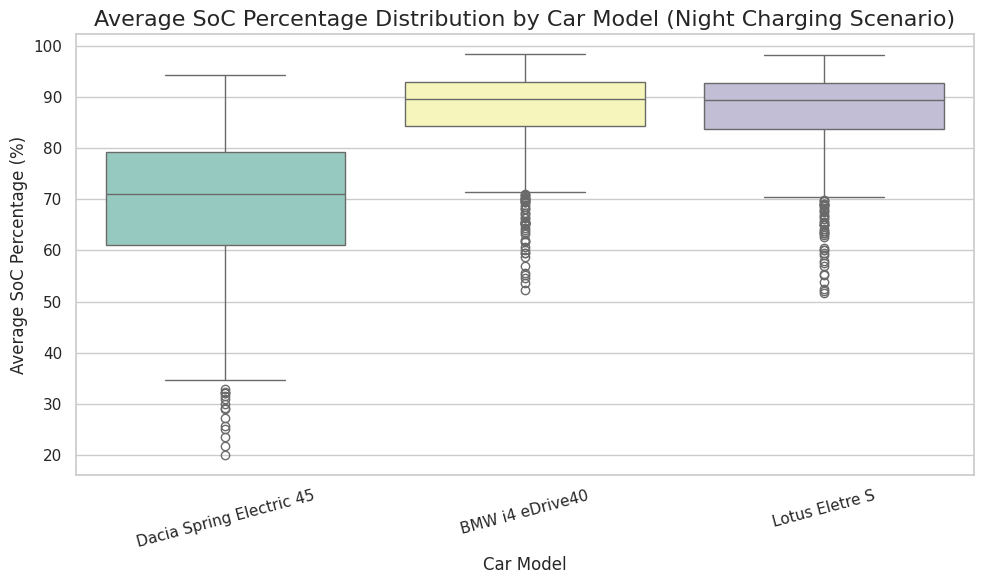

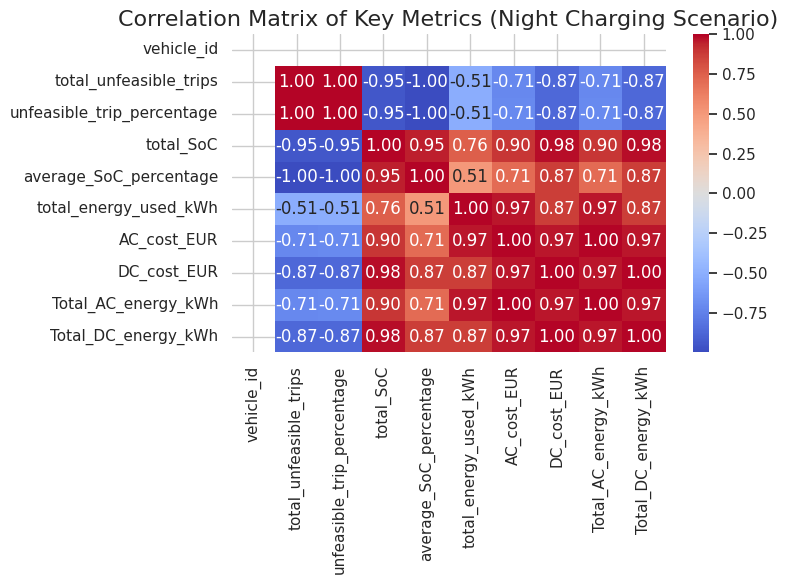

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. CARICAMENTO DEL DATASET
# ----------------------------
data = pd.read_csv(r"REFORMATTED_TRIPS.csv")

# Convertiamo le colonne temporali
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Assicuriamoci che start_date e end_date siano datetime (se non già così)
data['start_date'] = pd.to_datetime(data['start_date'])
data['end_date'] = pd.to_datetime(data['end_date'])

# --------------------------
# 2. SPECIFICHE DEI VEICOLI
# --------------------------
cars = {
    "Dacia Spring Electric 45": {
        "Useable Capacity": 25.0,  # kWh
        "AC": {
            "Charge Power": 6.6,  # kW
            "Charge Speed": 37,   # km/h (non strettamente necessario se calcoliamo via potenza)
            "Cost_per_kWh": 0.30
        },
        "DC": {
            "Charge Power (max)": 34,  # kW
            "Charge Speed": 180,       # km/h
            "Cost_per_kWh": 0.50
        },
        "Real_energy_consumption": {
            "Urban": 98,      # Wh/km
            "Highway": 172,   # Wh/km
            "Combined": 132   # Wh/km
        }
    },
    "BMW i4 eDrive40": {
        "Useable Capacity": 80.7,  # kWh
        "AC": {
            "Charge Power": 11,  # kW
            "Charge Speed": 60,  # km/h
            "Cost_per_kWh": 0.30
        },
        "DC": {
            "Charge Power (max)": 207,  # kW
            "Charge Speed": 800,
            "Cost_per_kWh": 0.50
        },
        "Real_energy_consumption": {
            "Urban": 109,
            "Highway": 166,
            "Combined": 136
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": 109.0,  # kWh
        "AC": {
            "Charge Power": 22,   # kW
            "Charge Speed": 82,   # km/h
            "Cost_per_kWh": 0.30
        },
        "DC": {
            "Charge Power (max)": 367,  # kW
            "Charge Speed": 1060,
            "Cost_per_kWh": 0.50
        },
        "Real_energy_consumption": {
            "Urban": 156,
            "Highway": 242,
            "Combined": 196
        }
    }
}

# ---------------------------------------------------------
# 3. FUNZIONE DI SIMULAZIONE CON RICARICA NOTTURNA REALISTICA
# ---------------------------------------------------------
def simulate_vehicle_realistic_night_charge(vehicle_data, car_specs,
                                            night_charge_start=22, night_charge_end=6):
    """
    Simulazione realistica:
      - consumo per la tratta in base al road type
      - verifica fattibilità
      - ricarica (AC/DC) durante le pause
      - ricarica notturna (AC) se l'auto è ferma di notte
        (esempio: dalle 22:00 di un giorno alle 06:00 del giorno successivo)
    """
    # Stato di carica (SoC) iniziale: supponiamo piena per semplicità.
    SoC = car_specs["Useable Capacity"] * 1000  # in Wh

    total_trips = 0
    total_unfeasible_trips = 0
    total_SoC = 0
    total_energy_used = 0  # in Wh

    ac_cost = 0
    dc_cost = 0
    total_ac_energy = 0
    total_dc_energy = 0

    # Per comodità, ordiniamo i viaggi in ordine cronologico
    vehicle_data = vehicle_data.sort_values(by="start_time")

    # Gruppo di viaggi per giorno: ci serve per sapere quando "finisce" la giornata
    # e possiamo simulare la ricarica notturna
    for date_day, daily_trips in vehicle_data.groupby(vehicle_data['start_time'].dt.date):

        # Ordiniamo i viaggi di quella singola giornata
        daily_trips = daily_trips.sort_values(by="start_time")

        for _, trip in daily_trips.iterrows():
            total_trips += 1

            # 1) Calcolo consumo
            road_type = trip["road"]
            distance = trip["total_distance"]  # km
            if road_type == "U":
                consumption_per_km = car_specs["Real_energy_consumption"]["Urban"]
            elif road_type == "A":
                consumption_per_km = car_specs["Real_energy_consumption"]["Highway"]
            else:
                consumption_per_km = car_specs["Real_energy_consumption"]["Combined"]

            energy_required = consumption_per_km * distance  # Wh
            total_energy_used += energy_required

            # 2) Controllo fattibilità
            if SoC >= energy_required:
                # Trip fattibile
                SoC -= energy_required
            else:
                # Trip non fattibile
                total_unfeasible_trips += 1
                SoC = 0  # Arriviamo a 0

            # 3) Ricarica durante la pausa (se >= 20 min come da esempio)
            pause_time = trip["pause_time_minutes"]  # in minuti
            if pd.notnull(pause_time) and pause_time >= 20:
                # Potenze in Wh/min
                ac_charge_power = car_specs["AC"]["Charge Power"] * 1000 / 60.0
                dc_charge_power = car_specs["DC"]["Charge Power (max)"] * 1000 / 60.0

                if pause_time < 30:
                    # Solo AC
                    energy_charged = ac_charge_power * pause_time
                    total_ac_energy += energy_charged
                    ac_cost += (energy_charged / 1000) * car_specs["AC"]["Cost_per_kWh"]
                elif 30 <= pause_time <= 60:
                    # Misto AC e DC
                    ac_time = pause_time * 0.5
                    dc_time = pause_time * 0.5
                    ac_energy = ac_charge_power * ac_time
                    dc_energy = dc_charge_power * dc_time
                    energy_charged = ac_energy + dc_energy

                    total_ac_energy += ac_energy
                    total_dc_energy += dc_energy
                    ac_cost += (ac_energy / 1000) * car_specs["AC"]["Cost_per_kWh"]
                    dc_cost += (dc_energy / 1000) * car_specs["DC"]["Cost_per_kWh"]
                else:
                    # Solo DC
                    energy_charged = dc_charge_power * pause_time
                    total_dc_energy += energy_charged
                    dc_cost += (energy_charged / 1000) * car_specs["DC"]["Cost_per_kWh"]

                # Rendimento
                energy_charged *= 0.95
                SoC += energy_charged
                # Non superiamo la capacità massima
                SoC = min(SoC, car_specs["Useable Capacity"] * 1000)

            # Aggiorniamo total_SoC (lo salviamo dopo ogni viaggio)
            total_SoC += SoC

        # 4) Finita la giornata, vediamo se possiamo ricaricare l'auto di notte
        #    Supponiamo che la notte inizi alle 22:00 e finisca alle 06:00 del giorno dopo
        #    e che l'auto resti ferma tutta la notte.
        #    Se i dati (stop_time) indicano che l'ultimo trip finisce prima delle 22:00,
        #    ipotizziamo che da quell'ora (22:00) alle 06:00 del giorno successivo
        #    ci siano 8 ore di AC a disposizione.

        # Per sapere l'ora in cui finisce l'ultimo trip del giorno:
        day_str = pd.to_datetime(str(date_day))
        last_trip_end = daily_trips["stop_time"].max()  # ultima stop_time del giorno

        # Costruiamo orari "fissi" per il giorno: 22:00 e 06:00 del giorno successivo
        night_start = pd.to_datetime(day_str.strftime("%Y-%m-%d") + f" {night_charge_start}:00:00")
        # Se la notte di ricarica si estende al giorno successivo
        # aggiungiamo 1 giorno se night_charge_end < night_charge_start
        if night_charge_end < night_charge_start:
            night_end = night_start + pd.Timedelta(days=1)
            night_end = night_end.replace(hour=night_charge_end, minute=0, second=0)
        else:
            # se night_charge_end > night_charge_start, rimaniamo nello stesso giorno
            night_end = night_start.replace(hour=night_charge_end, minute=0, second=0)

        # Se l'ultimo trip finisce prima di night_start, allora abbiamo tutto lo slot 22:00 -> 06:00
        # Altrimenti la ricarica inizia quando l'auto effettivamente si ferma dopo l'ultimo trip.
        if last_trip_end < night_start:
            charge_window_start = night_start
        else:
            # Se l'ultimo viaggio finisce oltre le 22:00, la ricarica notturna
            # parte solo dal termine effettivo del viaggio
            charge_window_start = last_trip_end

        # Se la fine del periodo notturno è dopo charge_window_start, calcoliamo le ore di ricarica
        if night_end > charge_window_start:
            night_charge_duration = (night_end - charge_window_start).total_seconds() / 3600.0  # in ore
            if night_charge_duration > 0:
                # Ricarica notturna in AC
                ac_power_kW = car_specs["AC"]["Charge Power"]
                energy_charged_Wh = ac_power_kW * 1000 * night_charge_duration  # Wh
                # Consideriamo un 95% di efficienza
                energy_charged_Wh *= 0.95

                # Aggiungiamo ai conteggi totali
                total_ac_energy += energy_charged_Wh
                ac_cost += (energy_charged_Wh / 1000) * car_specs["AC"]["Cost_per_kWh"]

                # Aggiorniamo SoC
                SoC += energy_charged_Wh
                SoC = min(SoC, car_specs["Useable Capacity"] * 1000)

    # Calcoliamo le metriche da restituire
    unfeasible_percentage = (total_unfeasible_trips / total_trips) * 100 if total_trips else 0
    average_SoC = total_SoC / total_trips if total_trips else 0

    return {
        "Unfeasible_trips": {
            "total": total_unfeasible_trips,
            "percentage": unfeasible_percentage
        },
        "Battery_average_SoC": {
            "total": total_SoC,
            "percentage": average_SoC / (car_specs["Useable Capacity"] * 1000) * 100
        },
        "Total_energy_used_kWh": total_energy_used / 1000,
        "AC_cost_EUR": ac_cost,
        "DC_cost_EUR": dc_cost,
        "Total_AC_energy_kWh": total_ac_energy / 1000,
        "Total_DC_energy_kWh": total_dc_energy / 1000
    }

# ---------------------------------------------------
# 4. ESEGUIAMO LA SIMULAZIONE PER TUTTI I VEICOLI E AUTO
# ---------------------------------------------------
results_night = []
for vehicle_id, vehicle_data in data.groupby("vehicle_id"):
    for car_name, car_specs in cars.items():
        result = simulate_vehicle_realistic_night_charge(vehicle_data, car_specs,
                                                         night_charge_start=22,
                                                         night_charge_end=6)
        results_night.append({
            "vehicle_id": vehicle_id,
            "car_model": car_name,
            "total_unfeasible_trips": result["Unfeasible_trips"]["total"],
            "unfeasible_trip_percentage": result["Unfeasible_trips"]["percentage"],
            "total_SoC": result["Battery_average_SoC"]["total"],
            "average_SoC_percentage": result["Battery_average_SoC"]["percentage"],
            "total_energy_used_kWh": result["Total_energy_used_kWh"],
            "AC_cost_EUR": result["AC_cost_EUR"],
            "DC_cost_EUR": result["DC_cost_EUR"],
            "Total_AC_energy_kWh": result["Total_AC_energy_kWh"],
            "Total_DC_energy_kWh": result["Total_DC_energy_kWh"]
        })

# Convertiamo i risultati in un DataFrame e salviamo
results_df_night = pd.DataFrame(results_night)
results_df_night.to_csv(r"EV_SIMULATION_RESULTS_NIGHT_CHARGING.csv", index=False)
print(results_df_night.head())

# --------------------------
# 5. VISUALIZZAZIONE RISULTATI
# --------------------------
sns.set_theme(style="whitegrid")

# Esempio 1: barplot con % viaggi non fattibili
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df_night,
    x="car_model",
    y="unfeasible_trip_percentage",
    ci=None,
    palette="Set2"
)
plt.title("Percentage of Unfeasible Trips by Car Model (Night Charging Scenario)", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Unfeasible Trip Percentage (%)", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Esempio 2: boxplot SoC medio
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df_night,
    x="car_model",
    y="average_SoC_percentage",
    palette="Set3"
)
plt.title("Average SoC Percentage Distribution by Car Model (Night Charging Scenario)", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Average SoC Percentage (%)", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Esempio 3: Heatmap delle correlazioni (media per modello)
corr_data_night = results_df_night.groupby("car_model").mean(numeric_only=True)
corr_matrix_night = corr_data_night.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_night, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Metrics (Night Charging Scenario)", fontsize=16)
plt.tight_layout()
plt.show()